In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/curated_data/course_crime.csv')
df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')

<Axes: xlabel='Crime type'>

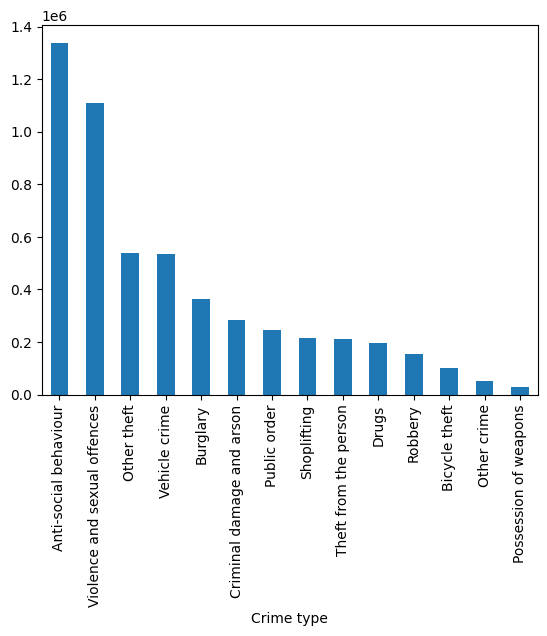

In [4]:
df['Crime type'].value_counts().plot(kind='bar')

<Axes: xlabel='Month'>

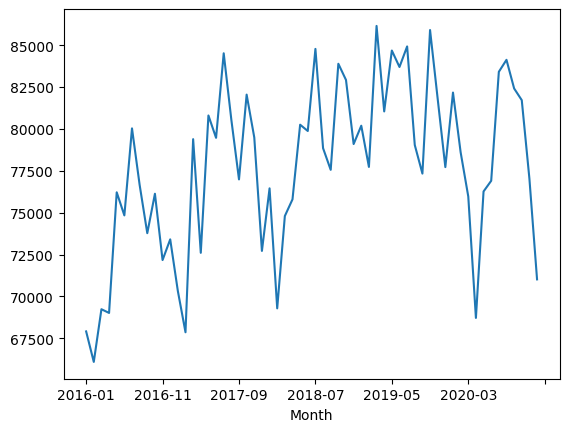

In [5]:
df.drop_duplicates(inplace=False)['Month'].value_counts().sort_index().plot(kind='line')
# .value_counts().sort_index().plot(kind='line')

### Survey data

In [6]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

effectiveness_questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E']
fairness_engagement_questions = ['Q62B', 'Q62C', 'A121']
accountability_questions = ['NQ135BH']
confidence_questions = ['Q65', 'Q21', 'Q131']

cols = ['MONTH', 'C2'] + ['Q150r', 'NQ149r', 'NQ155r', 'NQ147r', 'Q136r', 'XQ135r'] + effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions 

age_mapping = {'16-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65 or over': 6}


In [7]:
files = [
    "data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv"
]

all_data = pd.DataFrame()

# survey_columns = [
#     'MONTH', 'C2',
#     'Q79I', 'Q79B', 'Q79D', 'Q79E',  # Effectiveness
#     'Q62B', 'Q62C', 'A121',  # Fairness and engagement
#     'NQ135BH',  # Accountability
#     'Q65', 'Q21', 'Q131'  # Confidence
# ]

dataframes = []
for file in files:
    try:

        x = pd.read_csv(file)
        
        cols_to_select = [col for col in cols if col in x.columns]
        selected_df = x[cols_to_select]
        
        dataframes.append(selected_df)
        print(f"Loaded {file} with selected columns.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all the dataframes
surveys_df = pd.concat(dataframes, ignore_index=True)

Loaded data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv with selected columns.
Loaded data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv with selected columns.


In [8]:
surveys_demographics = surveys_df[cols]

### Encode demographic data

In [9]:
surveys_demographics.columns = [column_map[x] if x in column_map.keys() else x for x in surveys_demographics.columns]

surveys_demographics['is_hetero'] = (surveys_demographics['sexuality'] == 'Heterosexual').astype(int)
surveys_demographics['is_uk'] = (surveys_demographics['uk_citizen'] == 'UK').astype(int)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['religion'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['ethnicity'], drop_first=True)
surveys_demographics = pd.get_dummies(surveys_demographics, columns=['gender'], drop_first=True)
surveys_demographics['age_range'] = surveys_demographics['age'].map(age_mapping)

In [10]:
surveys_demographics['uk_citizen'].value_counts()

uk_citizen
UK        35941
Non-UK    27013
Name: count, dtype: int64

In [11]:
column_map = {
    'Q150r':'sexuality', 'NQ149r': 'religion', 'NQ155r':'uk_citizen', 'NQ147r': 'ethnicity', 'Q136r':'age', 'XQ135r':'gender'
}

In [12]:
label_to_value_map = {
    '1 Not at all well': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 Very well': 7,
    "Don't know": 97,
    'Refused': 98,
    'Not Asked': 99,

    'Strongly agree': 5,
    'Tend to agree': 4,
    'Neither agree nor disagree': 3,
    'Tend to disagree': 2,
    'Strongly disagree': 1,
    

    'Yes': 2,
    'No': 1,

    'Very confident': 4,
    'Fairly confident': 3,
    'Not very confident': 2,
    'Not at all confident': 1,

    'At least daily': 6,
    'At least weekly': 5,
    'At least fortnightly': 4,
    'At least monthly': 3,
    'Less often': 2,
    'Never': 1,

    'Very safe': 6,
    'Fairly safe': 5,
    'Fairly unsafe': 4,
    'Very unsafe': 2,
    '(spontaneous) Do not go out at all': 1,
    '(spontaneous) Do not go out alone': 3,

    'Very well informed': 3,
    'Fairly well informed': 2,
    'Not at all informed': 1
}

def label_to_value(label):
    return label_to_value_map.get(label, label)

In [13]:
questions = effectiveness_questions + fairness_engagement_questions + accountability_questions + confidence_questions

surveys_demographics[questions] = surveys_demographics[questions].applymap(label_to_value)



In [14]:
import seaborn as sns
import numpy as np
surveys_demographics.replace([97, 98, 99], np.nan, inplace=True)
# sns.heatmap(mock.isna())
# print(mock.dropna().shape)
surveys_demographics.dropna(inplace=True)

In [15]:
toselect = ['MONTH', 'C2', 'Q79I',
 'Q79B',
 'Q79D',
 'Q79E',
 'Q62B',
 'Q62C',
 'A121',
 'NQ135BH',
 'Q65',
 'Q21',
 'Q131',
 'is_hetero',
 'is_uk',
 'religion_Hindu',
 'religion_Muslim',
 'religion_No religion',
 'religion_Other religion',
 'ethnicity_Black',
 'ethnicity_Mixed',
 'ethnicity_Other',
 'ethnicity_White British',
 'ethnicity_White Other',
 'gender_Male',
 'gender_Other',
 'age_range']

surveys_demographics = surveys_demographics[toselect]


In [16]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

In [17]:
# independent_vars = [
#     'is_hetero', 'is_uk', 
#     'Q("religion_Hindu")', 'Q("religion_Muslim")', 'Q("religion_No religion")', 'Q("religion_Other religion")',
#     'Q("ethnicity_Black")', 'Q("ethnicity_Mixed")', 'Q("ethnicity_Other")', 'Q("ethnicity_White British")', 'Q("ethnicity_White Other")',
#     'gender_Male', 'gender_Other', 
#     'age_range'
# ]

# formula_parts = ['Q131 ~ '] + independent_vars
# formula = ' + '.join(formula_parts) + ' + ' + ' + '.join(f'{v1}:{v2}' for v1 in independent_vars for v2 in independent_vars if v1 != v2)
# model = ols(formula, data=surveys_demographics).fit()
# print(model.summary())

In [18]:
def adjust_Q79I(row):
    adjustment = 0

    # Main effects
    if row['ethnicity_White British'] == 1:
        adjustment += 11.9952

    # Interaction effects
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -7.9211
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -11.5516
    if row['is_hetero'] == 1 and row['gender_Other'] == 1:
        adjustment += 102.0781
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -3.919e-13  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 7.7939
    if row['religion_Other religion'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 11.9128
    if row['religion_Other religion'] == 1 and row['gender_Male'] == 1:
        adjustment += 4.2869

    # Apply the adjustment to the original Q79I response
    adjusted_response = row['Q79I'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79I'] = surveys_demographics.apply(adjust_Q79I, axis=1)

In [19]:
def adjustQ79B(row):
    adjustment = 0

    # Main effects
    if row['is_uk'] == 1:
        adjustment += -0.4738
    if row['ethnicity_Black'] == 1:
        adjustment += -0.5863
    if row['gender_Other'] == 1:
        adjustment += -3.9287

    # Interaction effects
    if row['is_hetero'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += -0.2297
    if row['is_uk'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += -0.1465
    if row['is_uk'] == 1 and row['ethnicity_White British'] == 1:
        adjustment += 0.1248
    if row['religion_Muslim'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.2666
    if row['religion_Muslim'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4384
    if row['religion_Muslim'] == 1 and row['ethnicity_Other'] == 1:
        adjustment += 0.1868
    if row['religion_Muslim'] == 1 and row['gender_Other'] == 1:
        adjustment += -1.322e-14  # This is effectively zero and can be ignored
    if row['religion_No religion'] == 1 and row['ethnicity_Black'] == 1:
        adjustment += 0.1846
    if row['religion_Other religion'] == 1 and row['ethnicity_Mixed'] == 1:
        adjustment += 0.4532
    if row['gender_Other'] == 1 and row['age_range'] != None:
        adjustment += 0.8285 * row['age_range']  # assuming age_range is scaled appropriately

    # Apply the adjustment to the original Q79B response
    adjusted_response = row['Q79B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79B'] = surveys_demographics.apply(adjustQ79B, axis=1)

In [20]:
def apply_Q79D(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.5579
    if row['ethnicity_Black']:
        adjustment += -0.6811
    if row['ethnicity_White British']:
        adjustment += -0.3519
    if row['ethnicity_White Other']:
        adjustment += -0.2897
    if row['age_range'] is not None:
        adjustment += -0.0715 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Mixed']:
        adjustment += -0.3923
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3674
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0763
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.2895
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3117
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5389
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.4505

    # Apply the adjustment to the original Q79D response
    adjusted_response = row['Q79D'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79D'] = surveys_demographics.apply(apply_Q79D, axis=1)


In [21]:
def apply_Q79E(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.6151
    if row['ethnicity_Black']:
        adjustment += -0.8268
    if row['ethnicity_White British']:
        adjustment += -0.3697
    if row['ethnicity_White Other']:
        adjustment += -0.2511
    if row['age_range'] is not None:
        adjustment += -0.0896 * row['age_range']

    # Interaction effects
    if row['is_hetero'] and row['ethnicity_Black']:
        adjustment += 0.2552
    if row['is_hetero'] and row['gender_Other']:
        adjustment += 3.4662
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.4410
    if row['religion_Hindu'] and row['religion_Other religion']:
        adjustment += 1.366e-14
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.3045
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.3155
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.4747
    if row['ethnicity_Mixed'] and row['gender_Other']:
        adjustment += 4.9951

    # Apply the adjustment to the original Q79E response
    adjusted_response = row['Q79E'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q79E'] = surveys_demographics.apply(apply_Q79E, axis=1)

In [22]:
def apply_Q62B(row):
    adjustment = 0

    # Main effects
    if row['is_uk']:
        adjustment += -0.2783
    if row['ethnicity_Black']:
        adjustment += -0.2289

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1994
    if row['religion_Hindu'] and row['ethnicity_Other']:
        adjustment += -0.3091
    if row['religion_Muslim'] and row['ethnicity_Mixed']:
        adjustment += 0.1767
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0259 * row['age_range']
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0345 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.1751
    if row['religion_Other religion'] and row['ethnicity_Mixed']:
        adjustment += 0.2160
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -5.14e-16
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0091 * row['age_range']

    # Apply the adjustment to the original Q62B response
    adjusted_response = row['Q62B'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62B'] = surveys_demographics.apply(apply_Q62B, axis=1)


In [23]:
def apply_Q62C(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2519
    if row['is_uk']:
        adjustment += -0.4766
    if row['ethnicity_Black']:
        adjustment += -0.3972

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.3184
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0930
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0263 * row['age_range']
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1593
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0897
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += 0.0247 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.5451
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.2072
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0391 * row['age_range']
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += -0.0122 * row['age_range']
    if row['ethnicity_White Other'] and row['gender_Other']:
        adjustment += -2.1980

    # Apply the adjustment to the original Q62C response
    adjusted_response = row['Q62C'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q62C'] = surveys_demographics.apply(apply_Q62C, axis=1)


In [24]:
def apply_A121(row):
    adjustment = 0

    # Main effects
    if row['is_hetero']:
        adjustment += 0.2989
    if row['is_uk']:
        adjustment += -0.3404
    if row['ethnicity_Black']:
        adjustment += -0.3090
    if row['gender_Other']:
        adjustment += -1.9573
    if row['religion_Muslim']:
        adjustment += 0.2123

    # Interaction effects
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += 0.1971
    if row['is_uk'] and row['gender_Male']:
        adjustment += 0.0648
    if row['is_uk'] and row['age_range'] is not None:
        adjustment += 0.0302 * row['age_range']
    if row['is_hetero'] and row['gender_Male']:
        adjustment += -0.0687
    if row['religion_Muslim'] and row['ethnicity_Black']:
        adjustment += 0.1214
    if row['religion_Muslim'] and row['ethnicity_White British']:
        adjustment += -0.1770
    if row['religion_Muslim'] and row['gender_Male']:
        adjustment += -0.0604
    if row['religion_No religion'] and row['ethnicity_White British']:
        adjustment += -0.1121
    if row['religion_No religion'] and row['ethnicity_White Other']:
        adjustment += -0.1506
    if row['religion_No religion'] and row['age_range'] is not None:
        adjustment += -0.0221 * row['age_range']
    if row['religion_Other religion'] and row['ethnicity_Black']:
        adjustment += -0.2855
    if row['religion_Other religion'] and row['ethnicity_White British']:
        adjustment += -0.1774
    if row['religion_Other religion'] and row['ethnicity_White Other']:
        adjustment += -0.1291
    if row['gender_Male'] and row['age_range'] is not None:
        adjustment += 0.0118 * row['age_range']

    # Apply the adjustment to the original A121 response
    adjusted_response = row['A121'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_A121'] = surveys_demographics.apply(apply_A121, axis=1)



In [25]:
def apply_NQ135BH(row):
    adjustment = 0

    # Interaction effects with significant p-values
    if row['is_uk'] and row['ethnicity_Black']:
        adjustment += -7.8897
    if row['is_uk'] and row['ethnicity_White British']:
        adjustment += -11.7729
    if row['religion_Other religion'] and row['ethnicity_Other']:
        adjustment += 13.5283
    if row['religion_Muslim'] and row['age_range'] is not None:
        adjustment += -1.4949 * row['age_range']
    if row['religion_Other religion'] and row['gender_Other']:
        adjustment += -3.409e-14

    # Apply the adjustment to the original NQ135BH response
    adjusted_response = row['NQ135BH'] + adjustment
    return adjusted_response

# Apply this function to the DataFrame
surveys_demographics['adjusted_NQ135BH'] = surveys_demographics.apply(apply_NQ135BH, axis=1)


In [26]:
def apply_Q65(row):
    base_value = 4.0303  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_hetero', 0) * (-0.2577)
    adjustment += row.get('is_uk', 0) * (-0.6862)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.3747)
    adjustment += row.get('gender_Male', 0) * 0.2339
    adjustment += row.get('age_range', 0) * (-0.1657)

    # Calculate final Q65 value
    final_q65 = base_value + adjustment
    return final_q65

# Apply this function to the DataFrame
surveys_demographics['adjusted_Q65'] = surveys_demographics.apply(apply_Q65, axis=1)


In [27]:
def apply_Q21(row):
    base_value = 5.5248  # Intercept from the regression model
    adjustment = 0

    # Adjustments based on significant predictors using dummy variables
    adjustment += row.get('is_hetero', 0) * (-0.2826)
    adjustment += row.get('is_uk', 0) * (-0.3778)
    adjustment += row.get('religion_Muslim', 0) * (-0.6364)
    adjustment += row.get('religion_No religion', 0) * (-0.1791)
    adjustment += row.get('religion_Other religion', 0) * (-0.4015)
    adjustment += row.get('ethnicity_Black', 0) * (-0.3826)
    adjustment += row.get('ethnicity_Mixed', 0) * (-0.4245)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.2529)
    adjustment += row.get('gender_Male', 0) * 0.1579

    # Calculate the final Q21 value
    final_q21 = base_value + adjustment
    return final_q21

       
surveys_demographics['adjusted_Q21'] = surveys_demographics.apply(apply_Q21, axis=1)


In [28]:
def apply_Q131(row):
    base_value = 1.4633  # Intercept
    adjustment = 0

    # Apply adjustments
    adjustment += row.get('is_uk', 0) * (-0.0959)
    adjustment += row.get('ethnicity_White Other', 0) * (-0.1221)

    # Calculate final Q131 value
    final_q131 = base_value + adjustment
    return final_q131

surveys_demographics['adjusted_Q131'] = surveys_demographics.apply(apply_Q131, axis=1)



### Mappings

In [29]:
"""
    TODO:
    1. Apply column aggregation on 'wrong' dataframes
    2. Merge dataframes from all years
    3. Run statistical analysis on merged dataframe
"""

"\n    TODO:\n    1. Apply column aggregation on 'wrong' dataframes\n    2. Merge dataframes from all years\n    3. Run statistical analysis on merged dataframe\n"

In [30]:
from sklearn.preprocessing import MinMaxScaler

def scale_columns(dataframe, columns_to_scale):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler to the selected columns and replace in dataframe
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

    return dataframe

In [31]:
cols2 = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E', 'adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121', 'adjusted_NQ135BH', 'adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

In [32]:
scaled_surveys_demographics = scale_columns(surveys_demographics, cols2)

In [33]:
grouped = scaled_surveys_demographics.groupby(['MONTH', 'C2']).median().reset_index()

effectiveness_questions = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E']
fairness_engagement_questions = ['adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121']
accountability_questions = ['adjusted_NQ135BH']
confidence_questions = ['adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']

# MAKE SURE MEAN IS CORRECT
grouped['Effectiveness'] = grouped[effectiveness_questions].mean(axis=1)
grouped['Fairness and Engagement'] = grouped[fairness_engagement_questions].mean(axis=1)
grouped['Accountability'] = grouped[accountability_questions].mean(axis=1)
grouped['Confidence Questions'] = grouped[confidence_questions].mean(axis=1)

# Calculate 'Trust' as the mean of the first three categories
grouped['Trust'] = grouped[['Effectiveness', 'Fairness and Engagement', 'Accountability']].mean(axis=1)

# Update 'Confidence' to be the mean of itself and 'Trust'
grouped['Confidence'] = grouped[['Confidence Questions', 'Trust']].mean(axis=1)

In [34]:
# Change the format of the month
grouped['Date'] = pd.to_datetime(grouped['MONTH'].str.extract(r'\((.*?)\)')[0], format='%b %Y')
grouped.sort_values('Date', inplace=True)
grouped['MONTH'] = grouped['Date'].dt.strftime('%b %Y')

In [35]:
final_grouped = grouped.groupby(['MONTH', 'C2']).mean().reset_index()

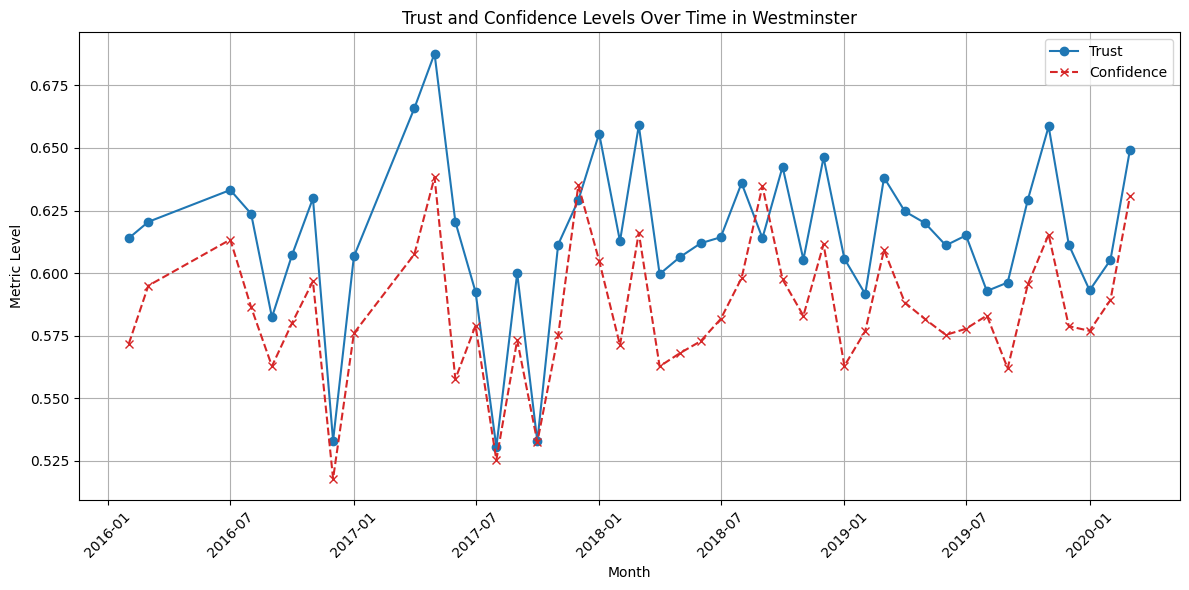

In [36]:
borough_data = final_grouped[final_grouped['C2'] == 'Westminster']
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'], format='%b %Y')
borough_data.sort_values('MONTH', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(borough_data['MONTH'], borough_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(borough_data['MONTH'], borough_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in Westminster')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

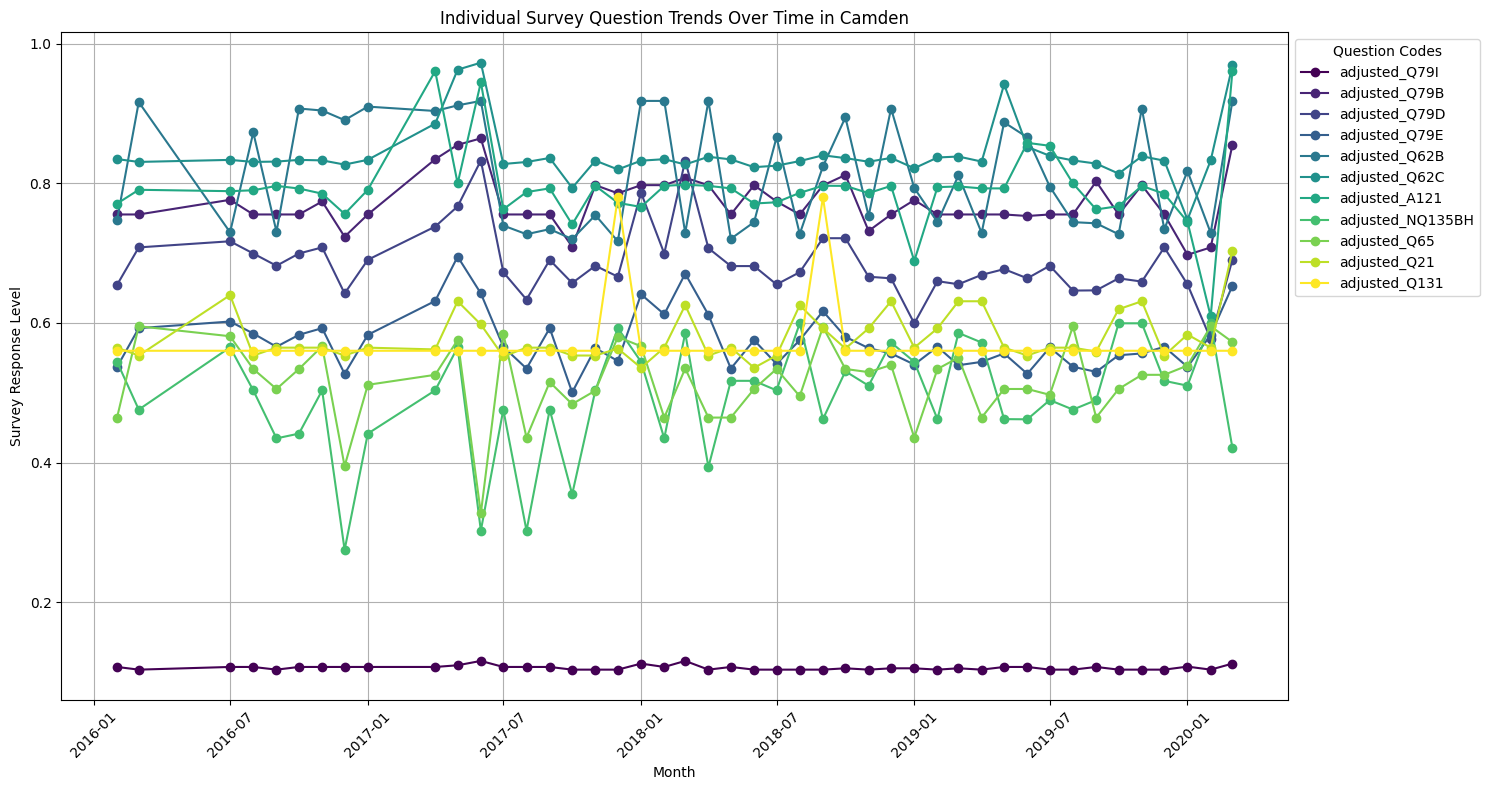

In [37]:
camden_data = final_grouped[final_grouped['C2'] == 'Westminster']
camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
camden_data = camden_data.sort_values('MONTH')

question_columns = ['Q79I', 'Q79B', 'Q79D', 'Q79E', 'Q62B', 'Q62C', 'A121', 'NQ135BH', 'Q65', 'Q21', 'Q131']

# Q79D has an issue

plt.figure(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(cols2)))
for i, col in enumerate(cols2):
    plt.plot(camden_data['MONTH'], camden_data[col], label=col, color=colors[i], marker='o', linestyle='-')

plt.title('Individual Survey Question Trends Over Time in Camden')
plt.xlabel('Month')
plt.ylabel('Survey Response Level')
plt.legend(title='Question Codes', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
PAS_file_path = "data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']

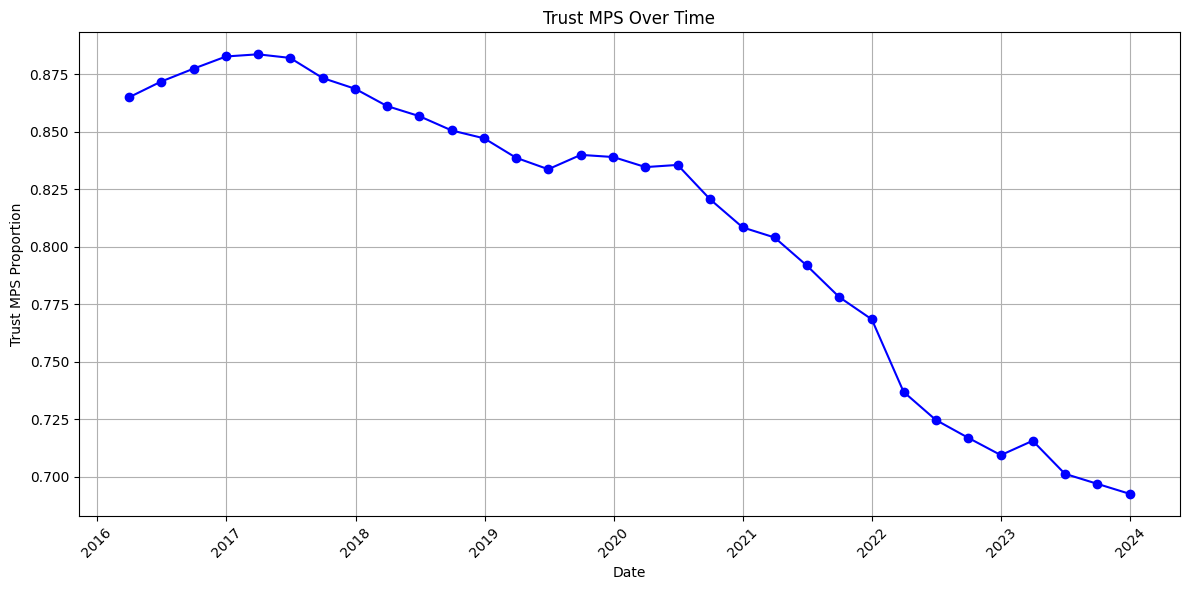

In [39]:
trust_mps_over_time = trust_data.groupby('Date')['Proportion'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(trust_mps_over_time['Date'], trust_mps_over_time['Proportion'], marker='o', linestyle='-', color='blue')
plt.title('Trust MPS Over Time')
plt.xlabel('Date')
plt.ylabel('Trust MPS Proportion')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

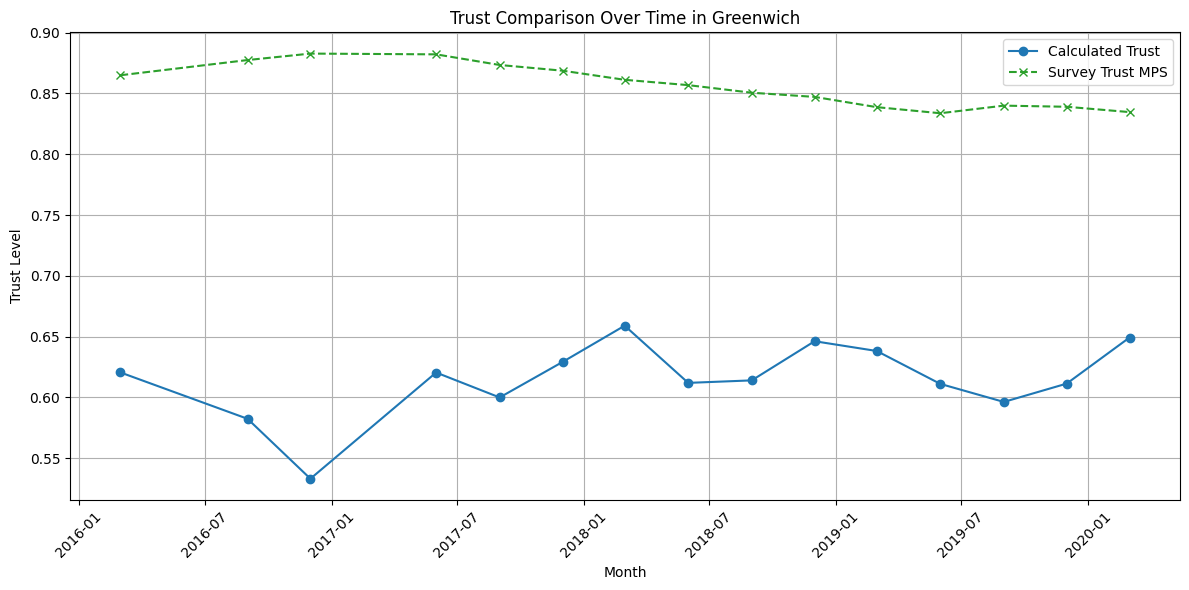

In [40]:
# PAS_file_path = "C:/Users/20220678/Microsoft VS Code/JBG050-DC2-Grp21/data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
# df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

# trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']
trust_mps_over_time['Date'] = pd.to_datetime(trust_mps_over_time['Date'], dayfirst=True)

# Change the Date to the start of the month to match with 'MONTH' in final_grouped
trust_mps_over_time['Month'] = trust_mps_over_time['Date'].dt.to_period('M').dt.to_timestamp()

combined_data_trust = pd.merge(borough_data, trust_mps_over_time[['Month', 'Proportion']], left_on='MONTH', right_on='Month', how='inner')

# Rename
combined_data_trust.rename(columns={'Proportion': 'Trust MPS'}, inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust'], color='tab:blue', marker='o', linestyle='-', label='Calculated Trust')
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust MPS'], color='tab:green', marker='x', linestyle='--', label='Survey Trust MPS')
plt.title('Trust Comparison Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Trust Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Confidence']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
               Trust  Confidence
Trust       1.000000    0.814304
Confidence  0.814304    1.000000


In [42]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Trust MPS']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
              Trust  Trust MPS
Trust      1.000000  -0.462922
Trust MPS -0.462922   1.000000


### Correlation of determinants of trust and confidence against Trust MPS

In [43]:
# effectiveness = grouped.groupby('Date').mean()[['Effectiveness']]
# fairness_engagement = grouped.groupby('Date').mean()[['Fairness and Engagement']]
# accountability = grouped.groupby('Date').mean()[['Accountability']]
# trust = grouped.groupby('Date').mean()[['Trust']]

# plt.plot(trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Date'],trust_mps_over_time[trust_mps_over_time['Date'] < '2021']['Proportion']  , label = "Trust MPS")
# plt.plot(effectiveness.reset_index()['Date'], effectiveness.reset_index()['Effectiveness'], label='Effectiveness')
# plt.plot(fairness_engagement.reset_index()['Date'], fairness_engagement.reset_index()['Fairness and Engagement'], label='Fairness and Engagement')
# plt.plot(accountability.reset_index()['Date'], accountability.reset_index()['Accountability'], label='Accountability')
# plt.plot(trust.reset_index()['Date'], trust.reset_index()['Trust'], label='trust')

# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.grid(True)

## Analyzing trends in crimes

In [44]:
final_grouped.to_csv('data/curated_data/final_grouped.csv', index=False)

In [45]:
# Plot crimes over time and compare with trust and confidence over time

crimes = pd.read_csv('data/curated_data/final_crimes.csv')

In [46]:
crime_outcomes_mapping = {
    "Investigation complete; no suspect identified": "unresolved",
    "Suspect charged": "resolved",
    "Local resolution": "resolved",
    "Offender given a caution": "resolved",
    "Offender given a drugs possession warning": "resolved",
    "Offender given penalty notice": "resolved",
    "Offender sent to prison": "resolved",
    "Defendant found not guilty": "resolved",
    "Offender given community sentence": "resolved",
    "Offender fined": "resolved",
    "Offender given suspended prison sentence": "resolved",
    "Offender given conditional discharge": "resolved",
    "Court case unable to proceed": "unresolved",
    "Offender otherwise dealt with": "resolved",
    "Offender ordered to pay compensation": "resolved",
    "Offender deprived of property": "resolved",
    "Suspect charged as part of another case": "resolved",
    "Offender given absolute discharge": "resolved",
    "Defendant sent to Crown Court": "resolved",
    "Formal action is not in the public interest": "resolved",
    "Unable to prosecute suspect": "unresolved"
}

crimes['Outcome'] = crimes['Last outcome category'].map(crime_outcomes_mapping)

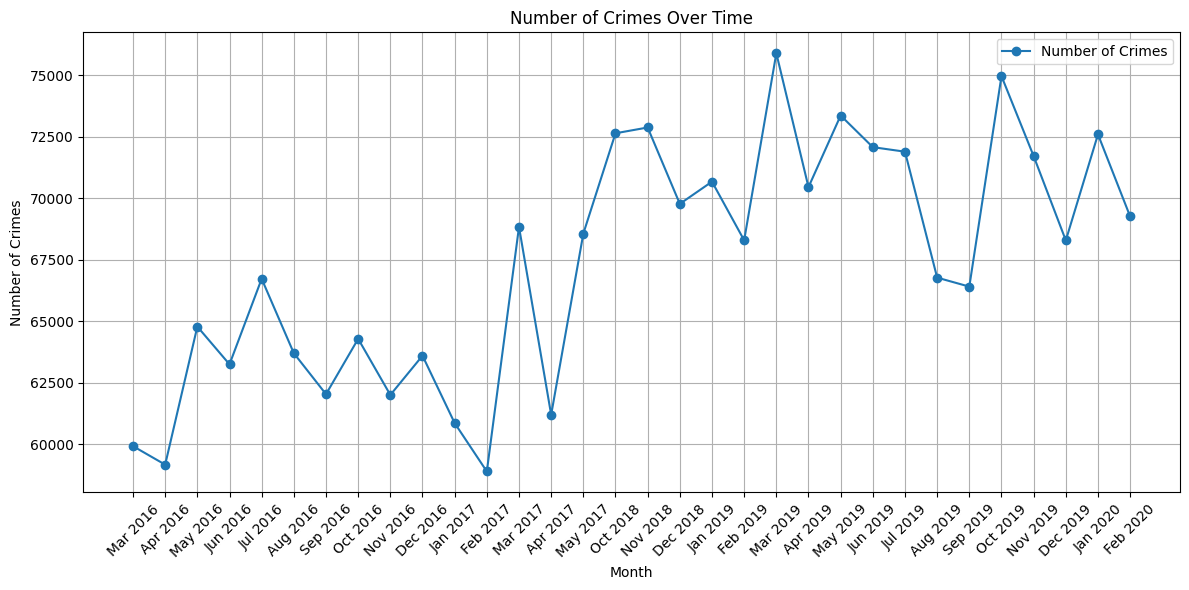

In [47]:
# Plot crimes over time and compare with trust and confidence over time

crimes['Month'] = pd.to_datetime(crimes['Month'], format='%Y-%m')
crimes = crimes[(crimes['Month'] > '2016-02-01') & (crimes['Month'] < '2020-03-01')]
crimes_over_time = crimes.groupby('Month').size().reset_index(name='Number of Crimes')
crimes_over_time = crimes_over_time.sort_values('Month')
crimes_over_time['Month'] = crimes_over_time['Month'].dt.strftime('%b %Y')


plt.figure(figsize=(12, 6))
plt.plot(crimes_over_time['Month'], crimes_over_time['Number of Crimes'], color='tab:blue', marker='o', linestyle='-', label='Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Get median trust and confidence for ALL boroughs
questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E', 'Q62B', 'Q62C', 'A121',
       'NQ135BH', 'Q65', 'Q21', 'Q131']
questions_adjusted = ['adjusted_Q79I', 'adjusted_Q79B',
       'adjusted_Q79D', 'adjusted_Q79E', 'adjusted_Q62B', 'adjusted_Q62C',
       'adjusted_A121', 'adjusted_NQ135BH', 'adjusted_Q65', 'adjusted_Q21',
       'adjusted_Q131']
determinants = ['Trust', 'Confidence', 'Effectiveness', 'Fairness and Engagement', 'Accountability', 'Confidence Questions']

trust_conf_grouped = final_grouped.groupby('Date')[determinants + questions_adjusted].median().reset_index()
trust_conf_grouped['Date'] = trust_conf_grouped['Date'].dt.strftime('%b %Y')

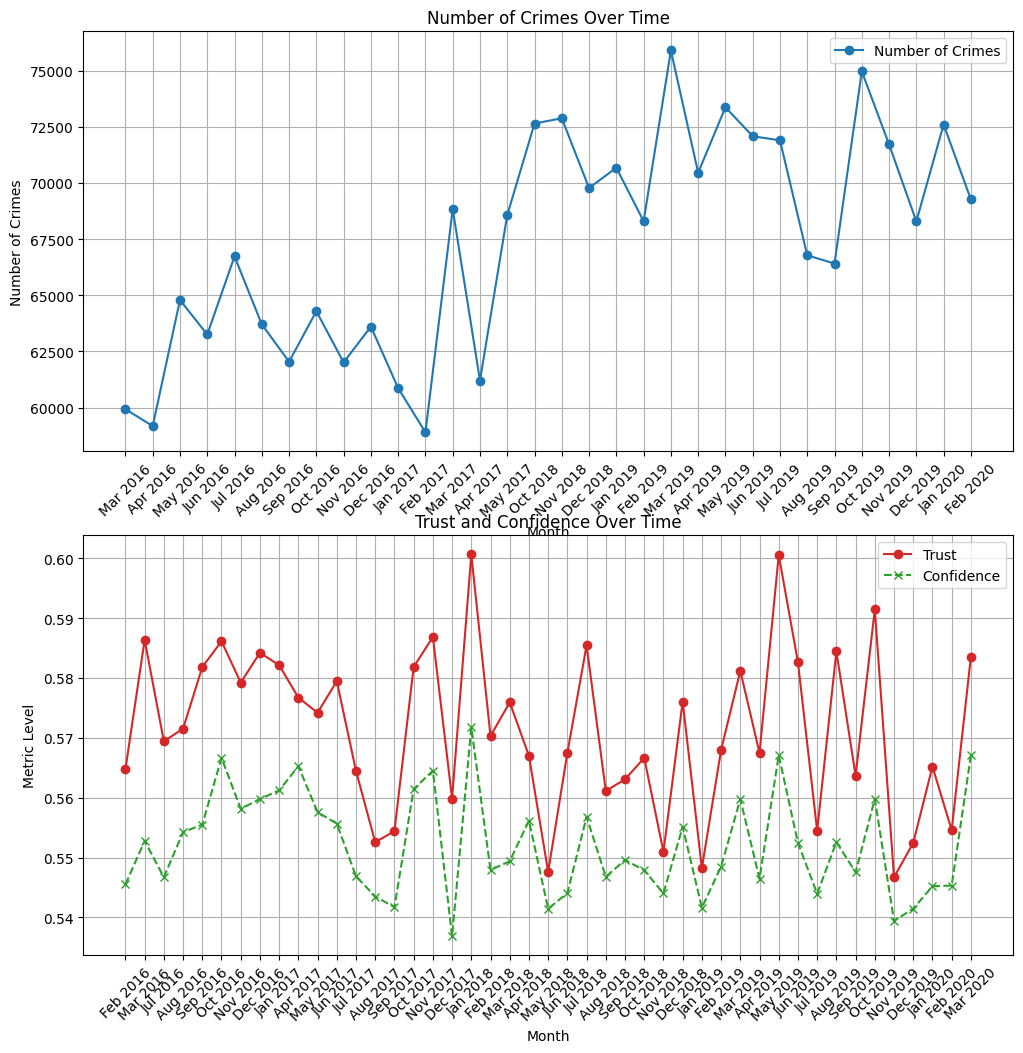

In [49]:
# do a subplot with the plot above, and a second plot with trust and confidence

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(crimes_over_time['Month'], crimes_over_time['Number of Crimes'], color='tab:blue', marker='o', linestyle='-', label='Number of Crimes')
ax[0].set_title('Number of Crimes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

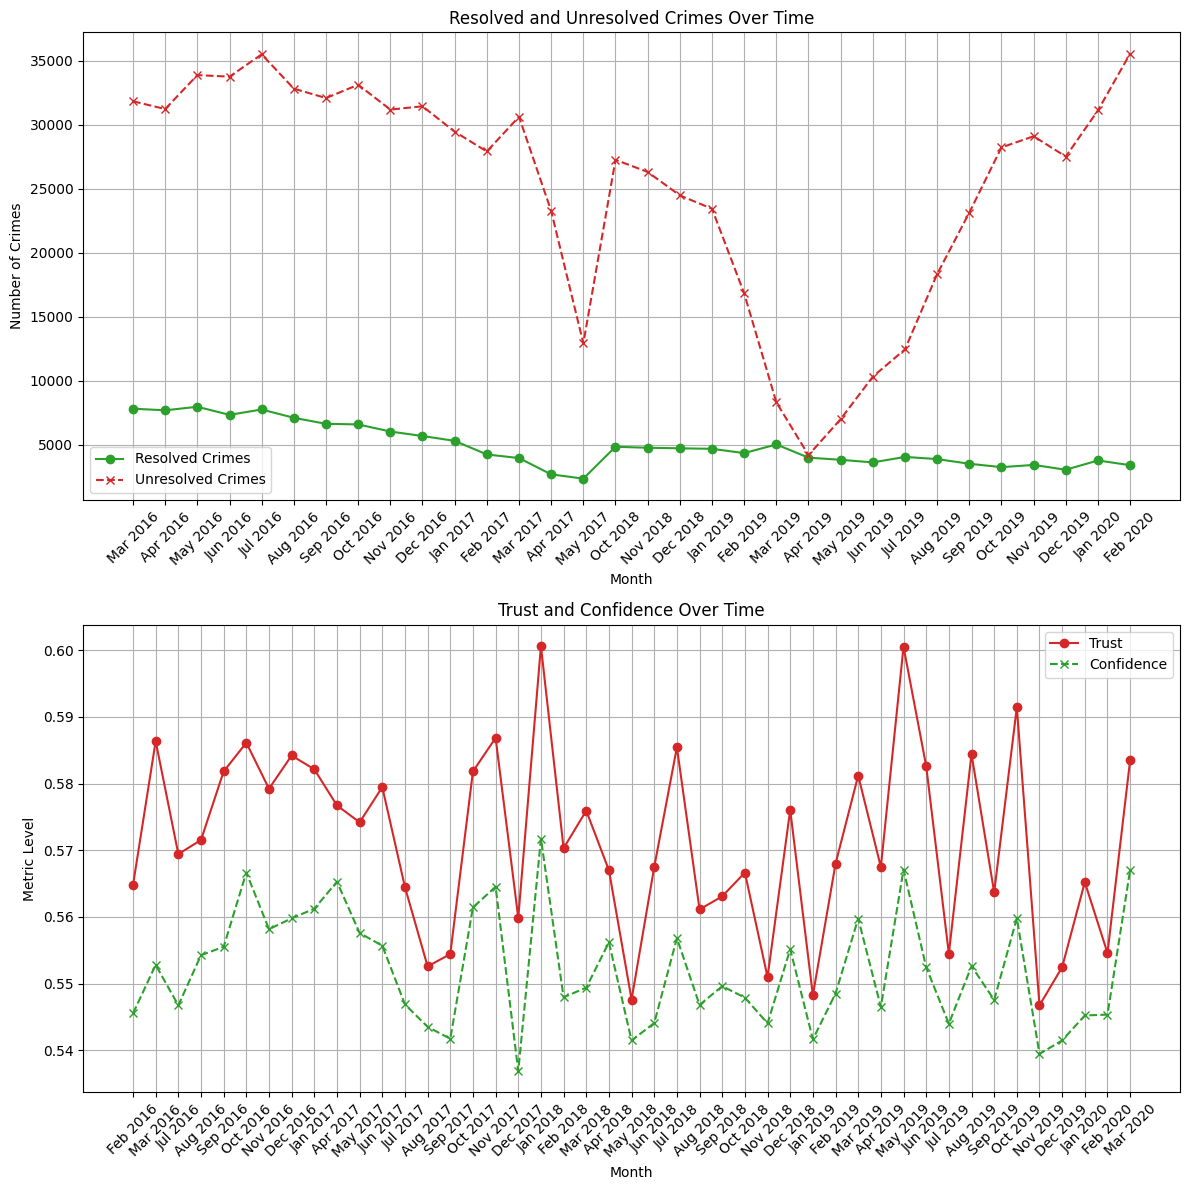

In [50]:
# instead of crimes over time against trust and confidence
# plot outcomes (by category, resolved and unresolved) over time against trust and confidence in subplots

outcomes_over_time = crimes.groupby(['Month', 'Outcome']).size().reset_index(name='Count')
outcomes_over_time = outcomes_over_time.pivot(index='Month', columns='Outcome', values='Count').reset_index()
outcomes_over_time = outcomes_over_time.fillna(0)
outcomes_over_time['Month'] = pd.to_datetime(outcomes_over_time['Month'], format='%Y-%m')
outcomes_over_time = outcomes_over_time[(outcomes_over_time['Month'] > '2016-02-01') & (outcomes_over_time['Month'] < '2020-03-01')]
outcomes_over_time['Month'] = outcomes_over_time['Month'].dt.strftime('%b %Y')

outcomes_over_time['resolved'] = outcomes_over_time['resolved'].astype(int)
outcomes_over_time['unresolved'] = outcomes_over_time['unresolved'].astype(int)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['resolved'], color='tab:green', marker='o', linestyle='-', label='Resolved Crimes')
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['unresolved'], color='tab:red', marker='x', linestyle='--', label='Unresolved Crimes')
ax[0].set_title('Resolved and Unresolved Crimes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

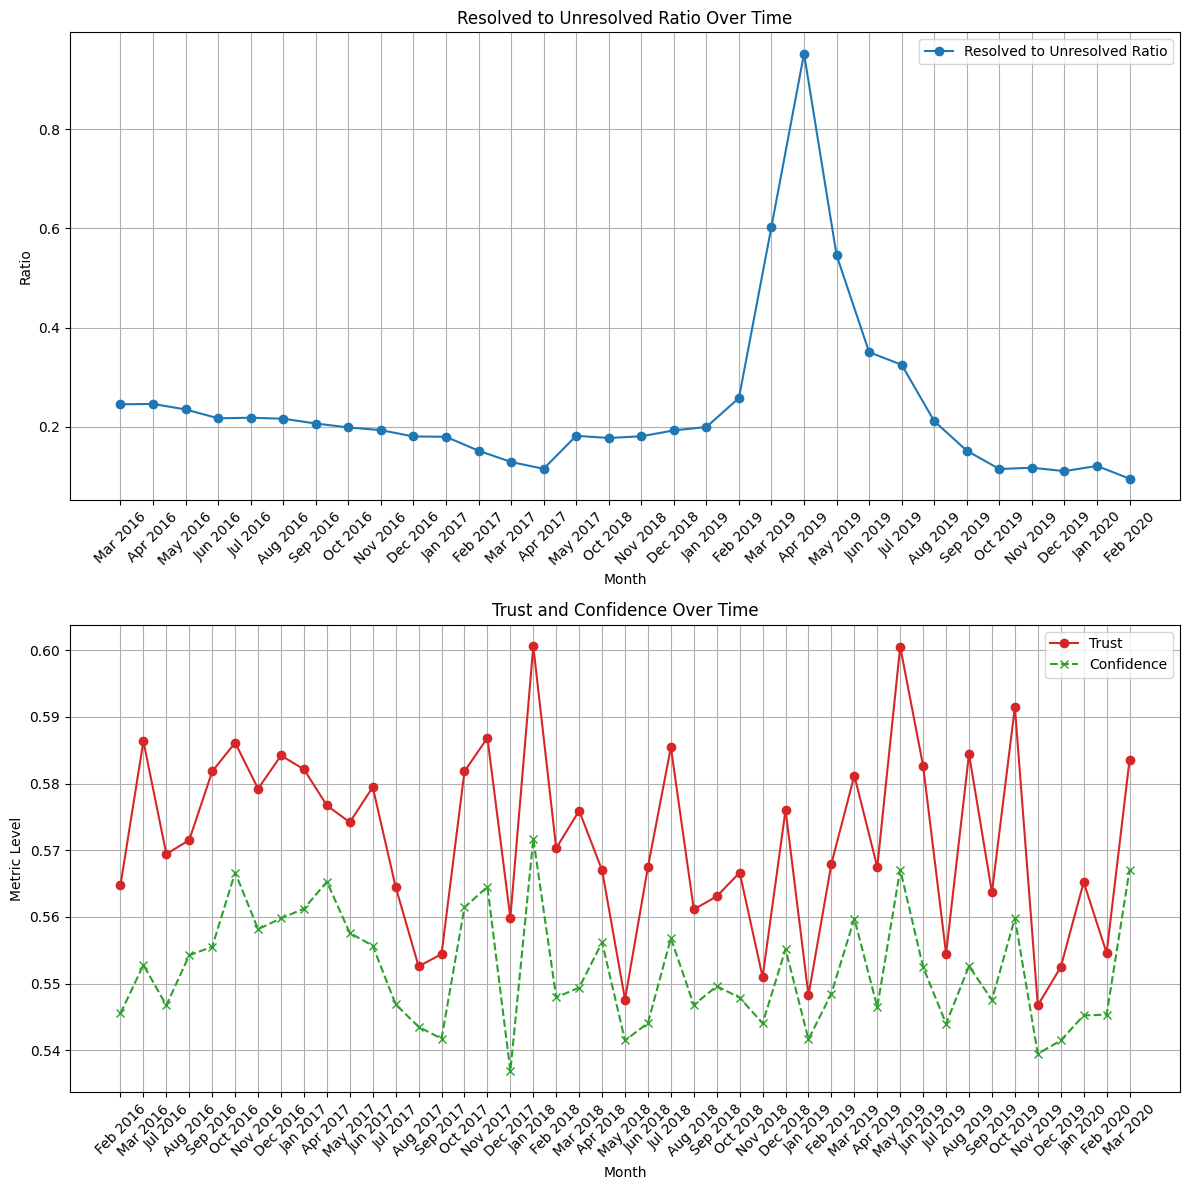

In [51]:
# instead of just resolved and unresolved, plot the ratio of resolved to unresolved crimes over time
# and make a subplot with trust and confidence over time just like above

outcomes_over_time['Resolved to Unresolved Ratio'] = outcomes_over_time['resolved'] / outcomes_over_time['unresolved']

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(outcomes_over_time['Month'], outcomes_over_time['Resolved to Unresolved Ratio'], color='tab:blue', marker='o', linestyle='-', label='Resolved to Unresolved Ratio')
ax[0].set_title('Resolved to Unresolved Ratio Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Ratio')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

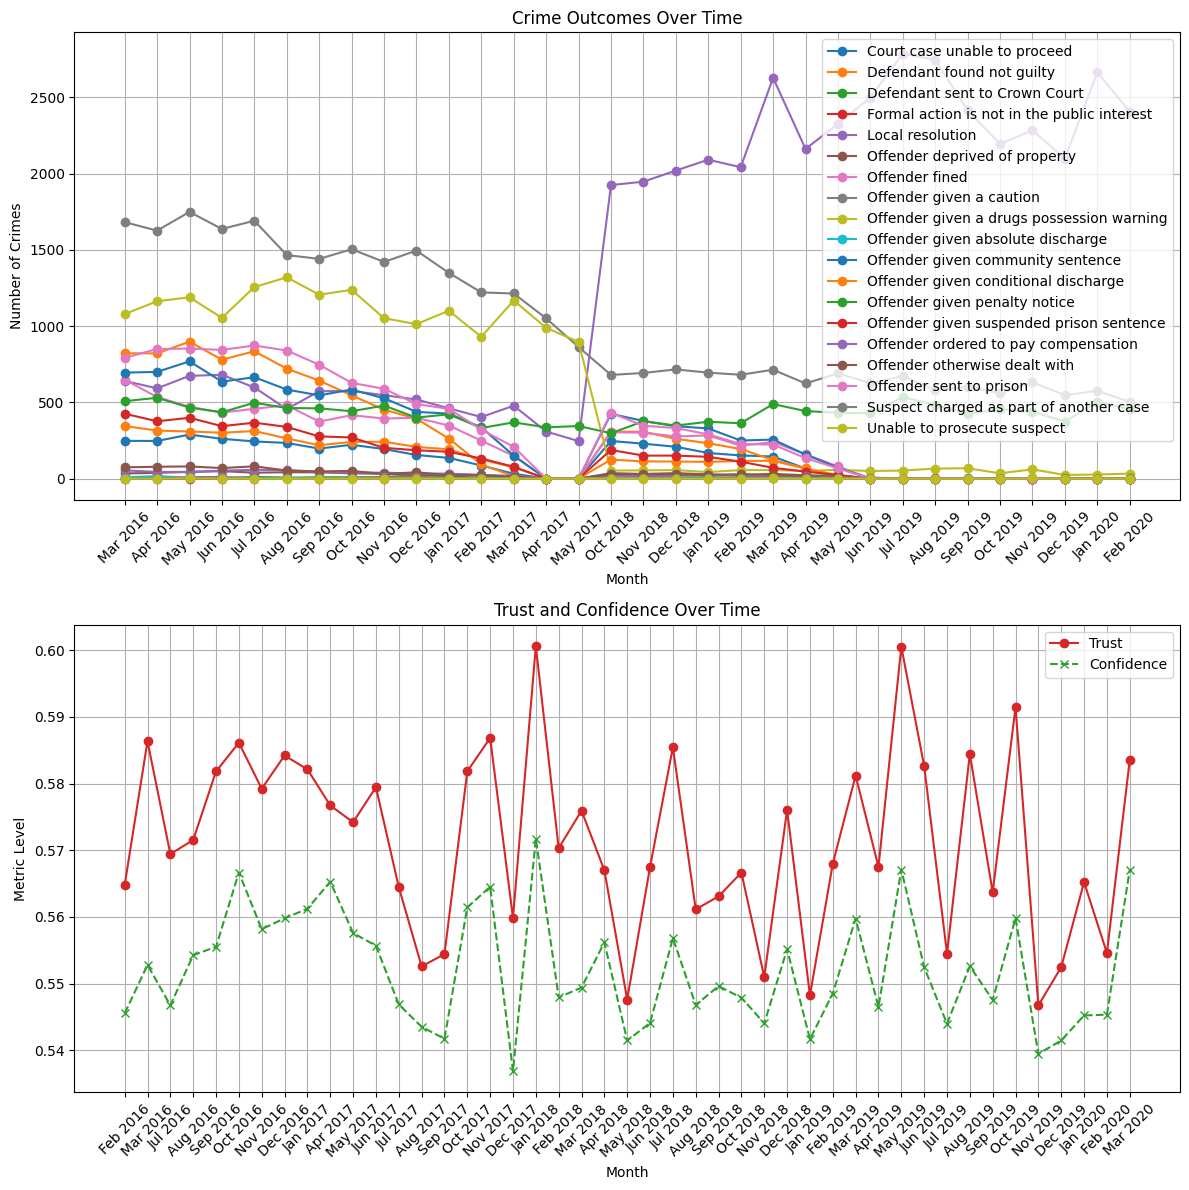

In [52]:
# now, instead of the ratio, plot different outcomes over time (except for 'Investigation complete; no suspect identified')
# and make a subplot with trust and confidence over time just like above

outcomes_over_time = crimes.groupby(['Month', 'Last outcome category']).size().reset_index(name='Count')
outcomes_over_time = outcomes_over_time.pivot(index='Month', columns='Last outcome category', values='Count').reset_index()
outcomes_over_time = outcomes_over_time.fillna(0)
outcomes_over_time['Month'] = pd.to_datetime(outcomes_over_time['Month'], format='%Y-%m')
outcomes_over_time = outcomes_over_time[(outcomes_over_time['Month'] > '2016-02-01') & (outcomes_over_time['Month'] < '2020-03-01')]
outcomes_over_time['Month'] = outcomes_over_time['Month'].dt.strftime('%b %Y')

outcomes_over_time = outcomes_over_time.drop(columns=['Investigation complete; no suspect identified'])
outcomes_over_time = outcomes_over_time.drop(columns=['Status update unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Court result unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Awaiting court outcome'])
outcomes_over_time = outcomes_over_time.drop(columns=['Under investigation'])

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in outcomes_over_time.columns[1:]:
    ax[0].plot(outcomes_over_time['Month'], outcomes_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Crime Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


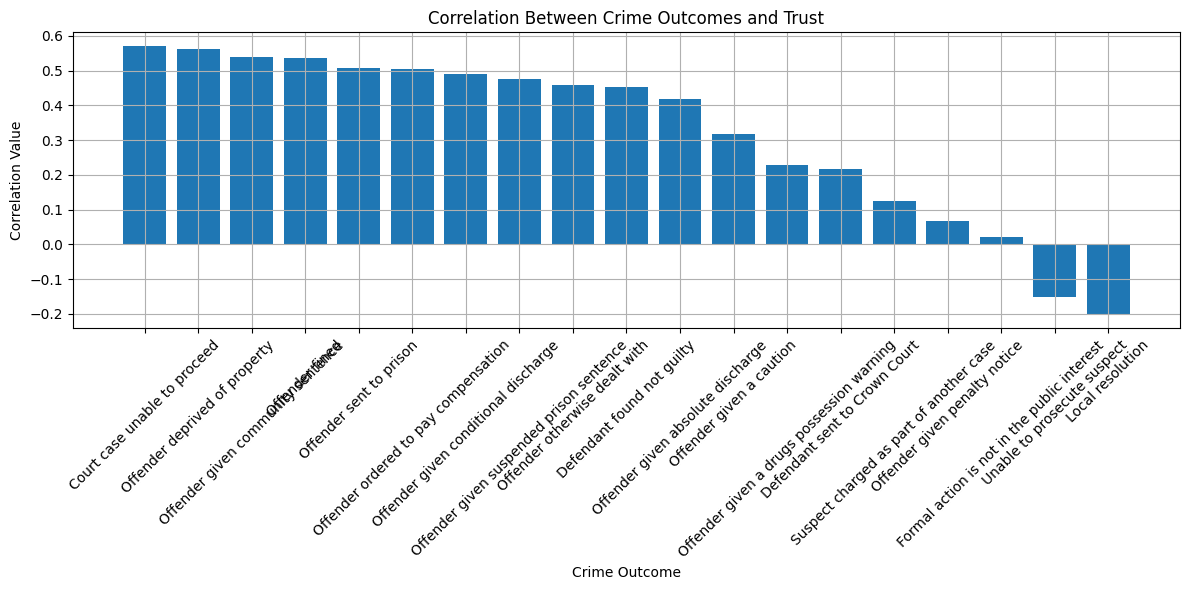

In [53]:
# Compute the correlation between the types of crime outcomes and trust and confidence
# and plot the correlation values in a bar chart
# ignore the date for now

outcomes_temp = outcomes_over_time.drop(columns=['Month'])
correlation_outcomes = outcomes_temp.corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Crime Outcomes and Trust')
plt.xlabel('Crime Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

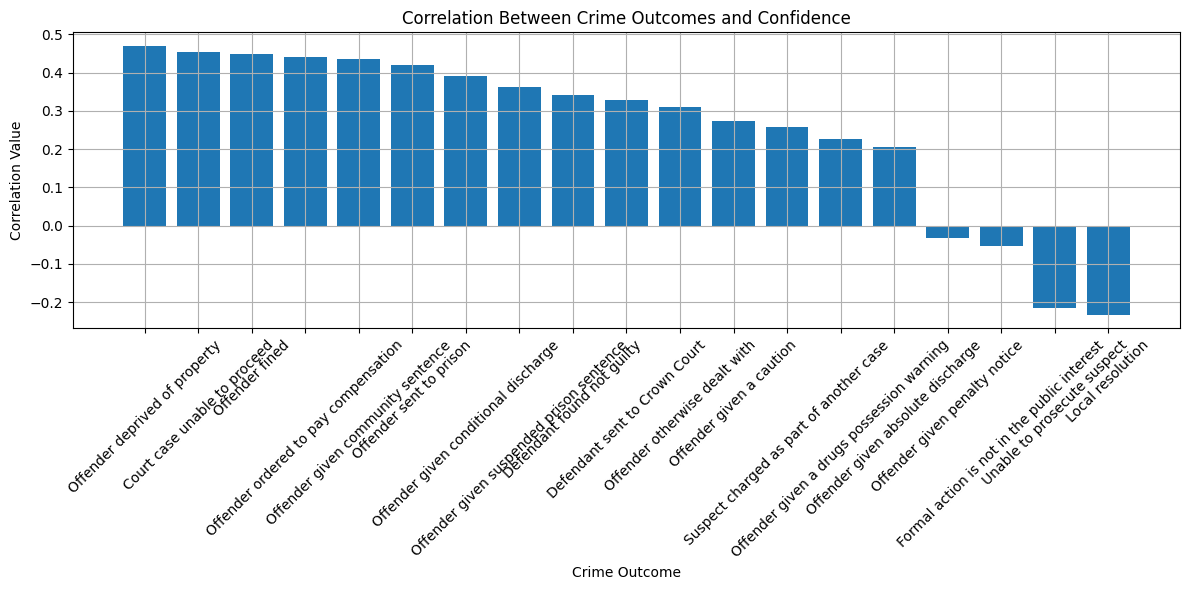

In [54]:
# Do the same for confidence

correlation_outcomes = outcomes_temp.corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Crime Outcomes and Confidence')
plt.xlabel('Crime Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Combining data for modelling (later on)

In [143]:
crime_outcomes_columns = outcomes_over_time.columns[1:]
crime_outcomes_columns = [f'C_O_{col}' for col in crime_outcomes_columns]
crime_outcomes_columns.insert(0, 'Date') 

x = outcomes_over_time.copy(deep=True)
x.columns = crime_outcomes_columns

final_analysis_df = pd.merge(trust_conf_grouped, x, on='Date', how='inner')

## Analyze Stop and Search data

In [56]:
## now analyze stop and search data
df_stop_search = pd.read_csv('data/curated_data/course_stop_and_search.csv')
df_stop_search = df_stop_search[~df_stop_search['Outcome'].isna()]
df_stop_search['Date'] = df_stop_search['Date'].str.split('T').str[0] # matches the YYYY-MM-DD format
# convert to datetime
df_stop_search['Date'] = pd.to_datetime(df_stop_search['Date'], format='%Y-%m-%d')
# Get data only from Feb 2016 to March 2020
df_stop_search = df_stop_search[(df_stop_search['Date'] > '2016-02-01') & (df_stop_search['Date'] < '2020-03-01')]

usuals = ['A no further action disposal', 'Nothing found - no further action', 'Article found - Detailed outcome unavailable']

df_stop_search_usual = df_stop_search[df_stop_search['Outcome'].isin(usuals)]
df_stop_search_unusual = df_stop_search[~df_stop_search['Outcome'].isin(usuals)]

unusual_outcome_mappings = {
    'Arrest': 'resolved',
    'Suspect arrested': 'resolved',
    'Community resolution': 'resolved',
    'Offender given drugs possession warning': 'warning',
    'Khat or Cannabis warning': 'warning',
    'Summons / charged by post': 'resolved',
    'Penalty Notice for Disorder': 'warning',
    'Local resolution': 'resolved',
    'Suspect summonsed to court': 'resolved',
    'Offender given penalty notice': 'warning',
    'Caution (simple or conditional)': 'warning',
    'Offender cautioned': 'warning',
    'Suspected psychoactive substances seized - No further action': 'resolved',
}

df_stop_search_unusual['Mapped_Outcomes'] = df_stop_search_unusual['Outcome'].map(unusual_outcome_mappings)

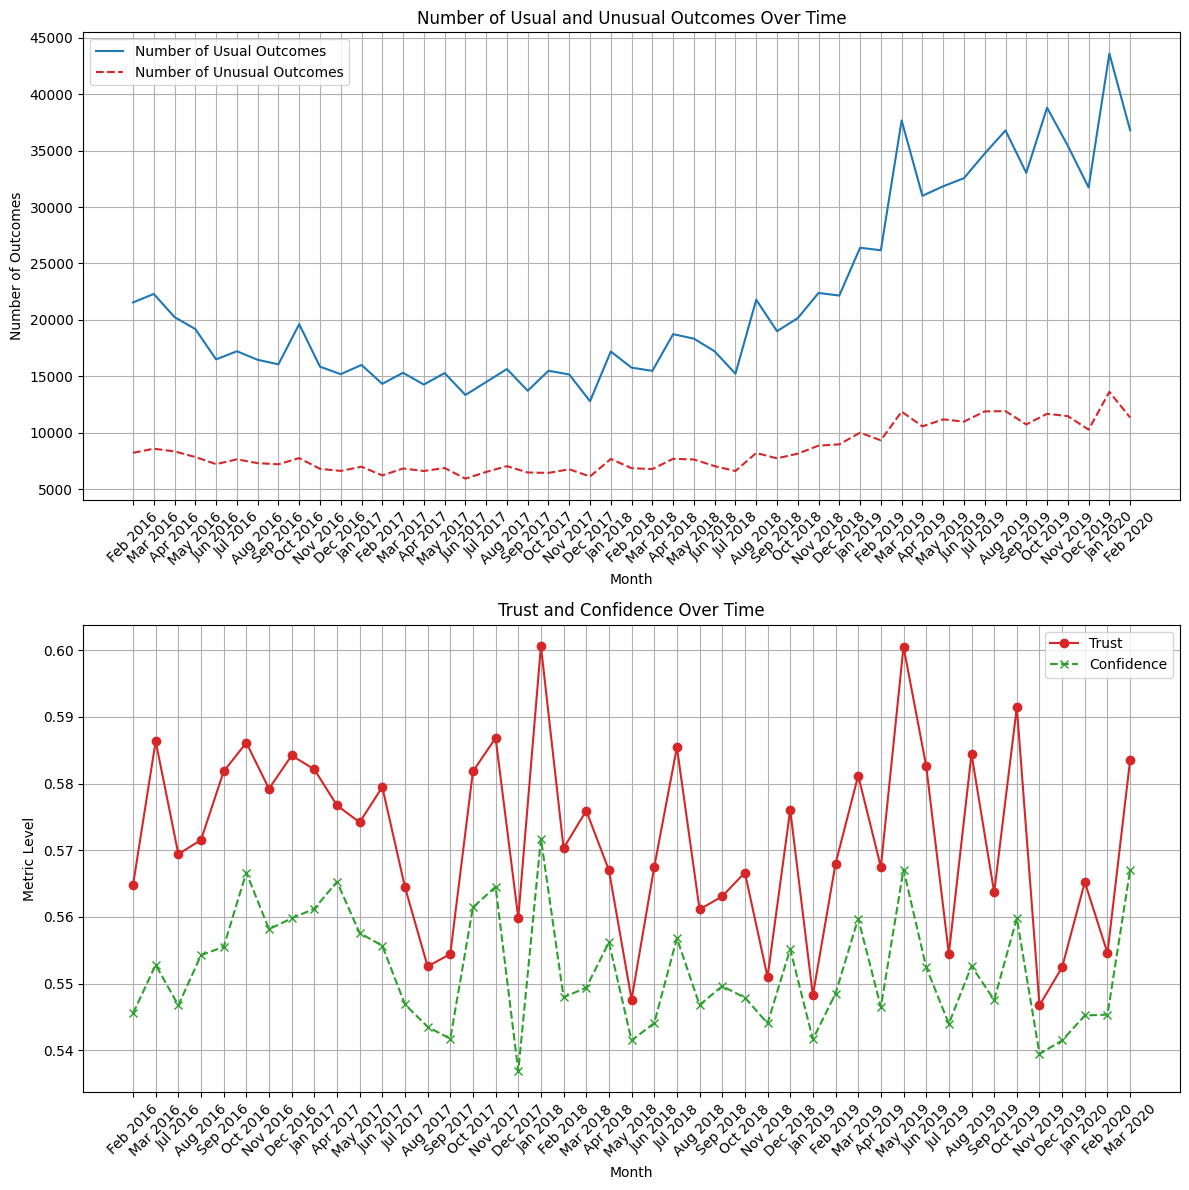

In [57]:
# Like before, compare the number of usual and unusual outcomes over time against trust and confidence

stop_search_usual_over_time = df_stop_search_usual.groupby(pd.Grouper(key='Date', freq='M')).size().reset_index(name='Number of Usual Outcomes')
stop_search_usual_over_time = stop_search_usual_over_time.sort_values('Date')
stop_search_usual_over_time['Date'] = stop_search_usual_over_time['Date'].dt.strftime('%b %Y')

stop_search_unusual_over_time = df_stop_search_unusual.groupby(pd.Grouper(key='Date', freq='M')).size().reset_index(name='Number of Unusual Outcomes')
stop_search_unusual_over_time = stop_search_unusual_over_time.sort_values('Date')
stop_search_unusual_over_time['Date'] = stop_search_unusual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(stop_search_usual_over_time['Date'], stop_search_usual_over_time['Number of Usual Outcomes'], color='tab:blue', linestyle='-', label='Number of Usual Outcomes')
ax[0].plot(stop_search_unusual_over_time['Date'], stop_search_unusual_over_time['Number of Unusual Outcomes'], color='tab:red', linestyle='--', label='Number of Unusual Outcomes')
ax[0].set_title('Number of Usual and Unusual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

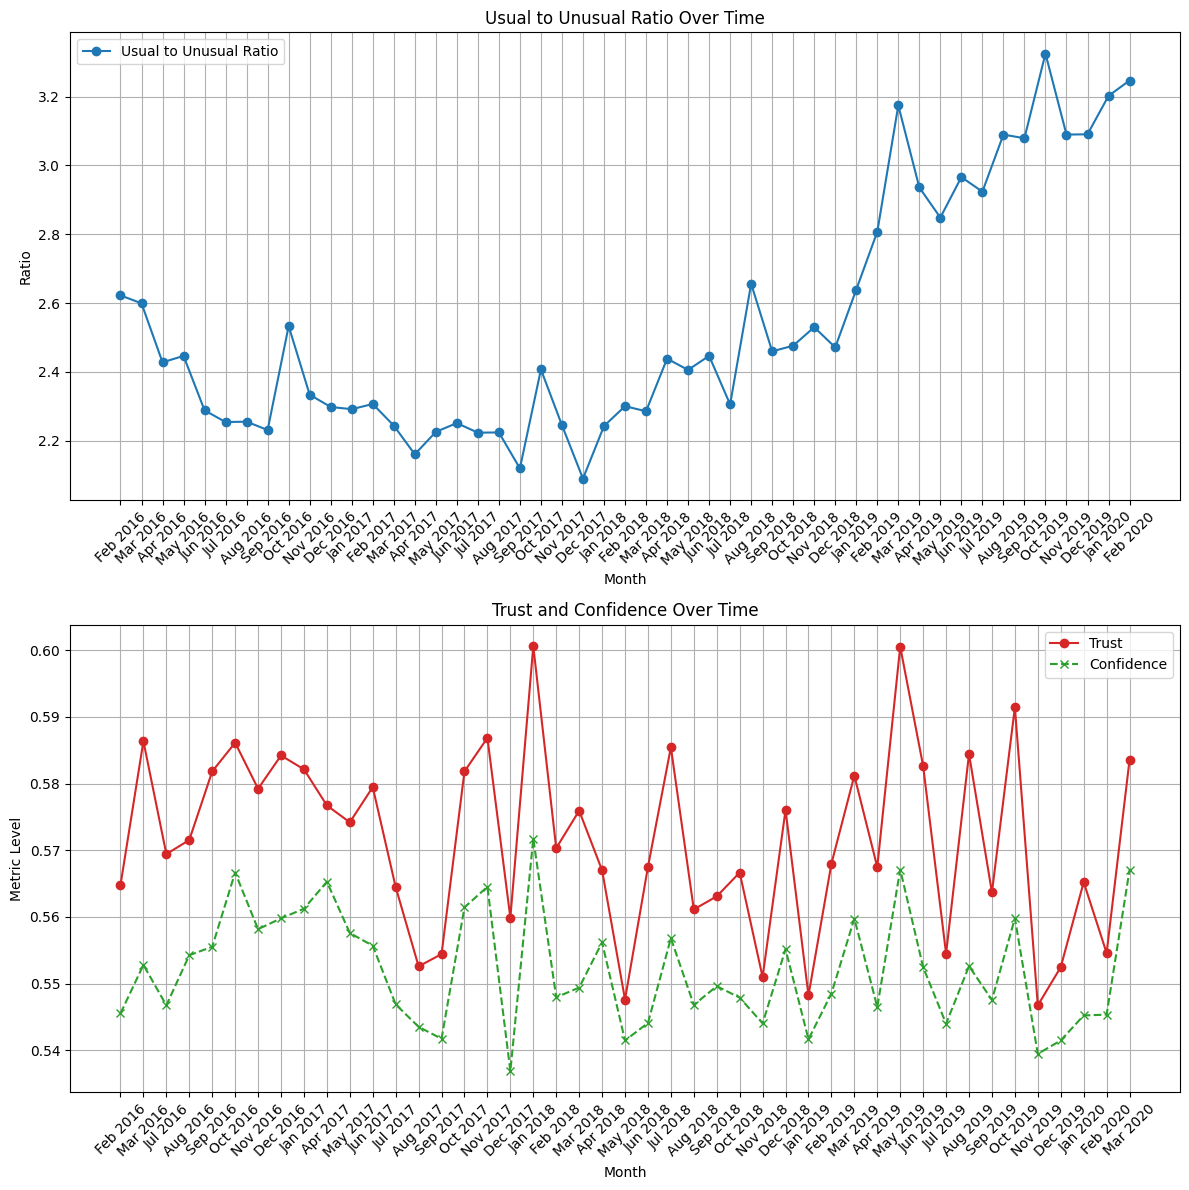

In [58]:
# now, instead of just usual and unusual, plot the ratio of usual to unusual outcomes over time
# and make a subplot with trust and confidence over time just like above

stop_search_usual_over_time['Number of Unusual Outcomes'] = stop_search_unusual_over_time['Number of Unusual Outcomes']
stop_search_usual_over_time['Usual to Unusual Ratio'] = stop_search_usual_over_time['Number of Usual Outcomes'] / stop_search_usual_over_time['Number of Unusual Outcomes']

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(stop_search_usual_over_time['Date'], stop_search_usual_over_time['Usual to Unusual Ratio'], color='tab:blue', marker='o', linestyle='-', label='Usual to Unusual Ratio')
ax[0].set_title('Usual to Unusual Ratio Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Ratio')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

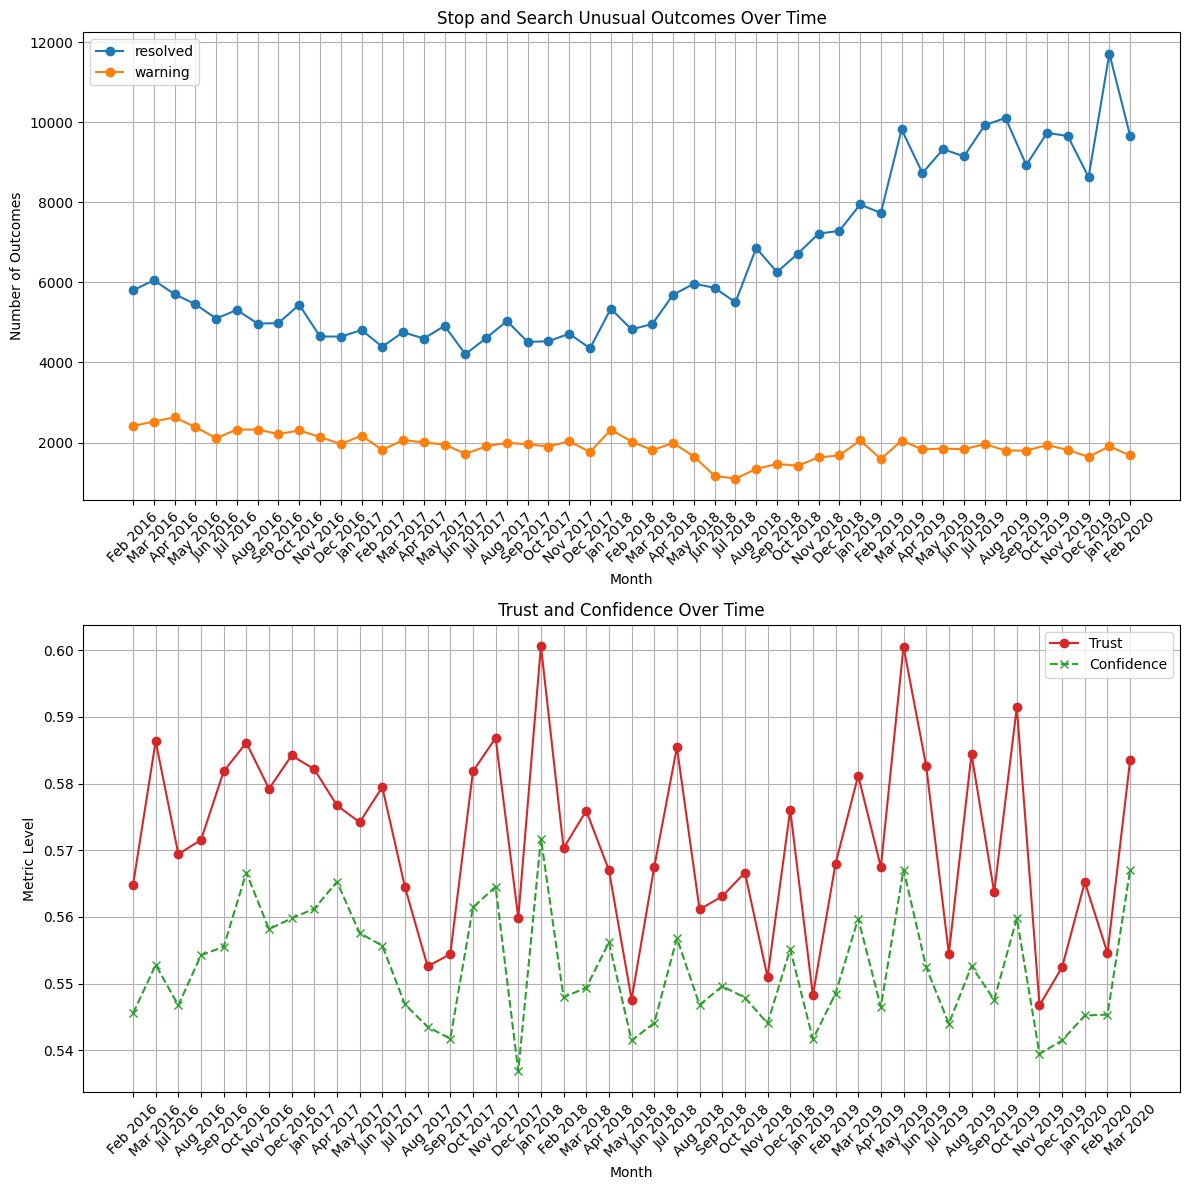

In [59]:
## now, analyze the mapped outcomes

stop_search_unusual_over_time = df_stop_search_unusual.groupby([pd.Grouper(key='Date', freq='M'), 'Mapped_Outcomes']).size().reset_index(name='Count')
stop_search_unusual_over_time = stop_search_unusual_over_time.pivot(index='Date', columns='Mapped_Outcomes', values='Count').reset_index()
stop_search_unusual_over_time = stop_search_unusual_over_time.fillna(0)
stop_search_unusual_over_time['Date'] = stop_search_unusual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in stop_search_unusual_over_time.columns[1:]:
    ax[0].plot(stop_search_unusual_over_time['Date'], stop_search_unusual_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Stop and Search Unusual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

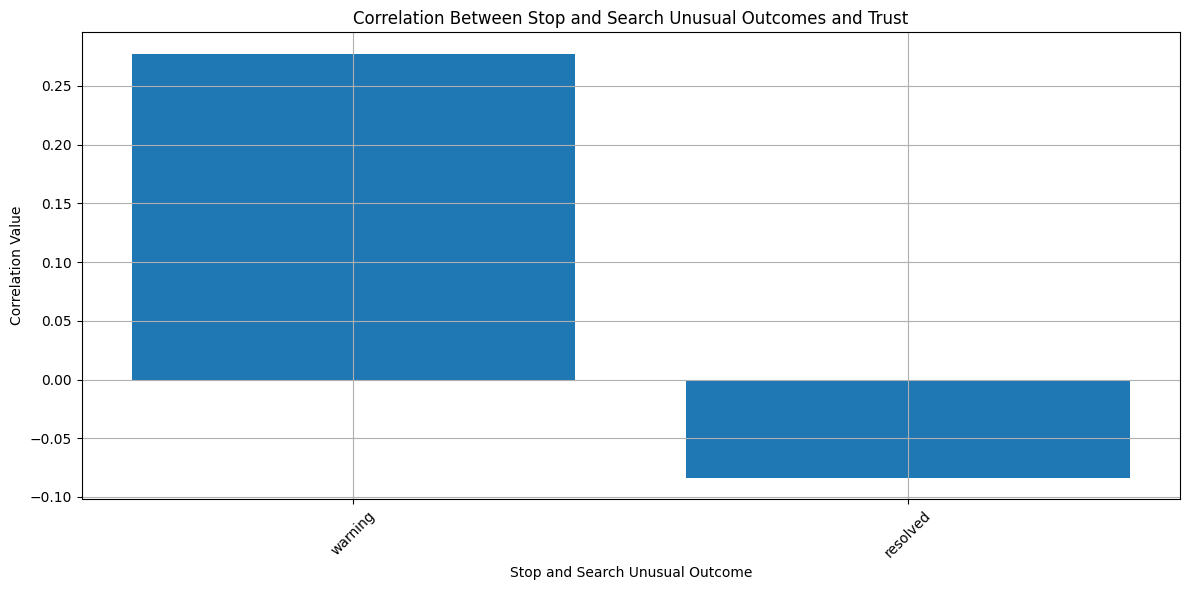

In [60]:
# Compute the correlation between the types of stop and search outcomes and trust and confidence
# and plot the correlation values in a bar chart
# ignore the date for now

stop_search_unusual_over_time_temp = stop_search_unusual_over_time.drop(columns=['Date'])
correlation_outcomes = stop_search_unusual_over_time_temp.corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Unusual Outcomes and Trust')
plt.xlabel('Stop and Search Unusual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

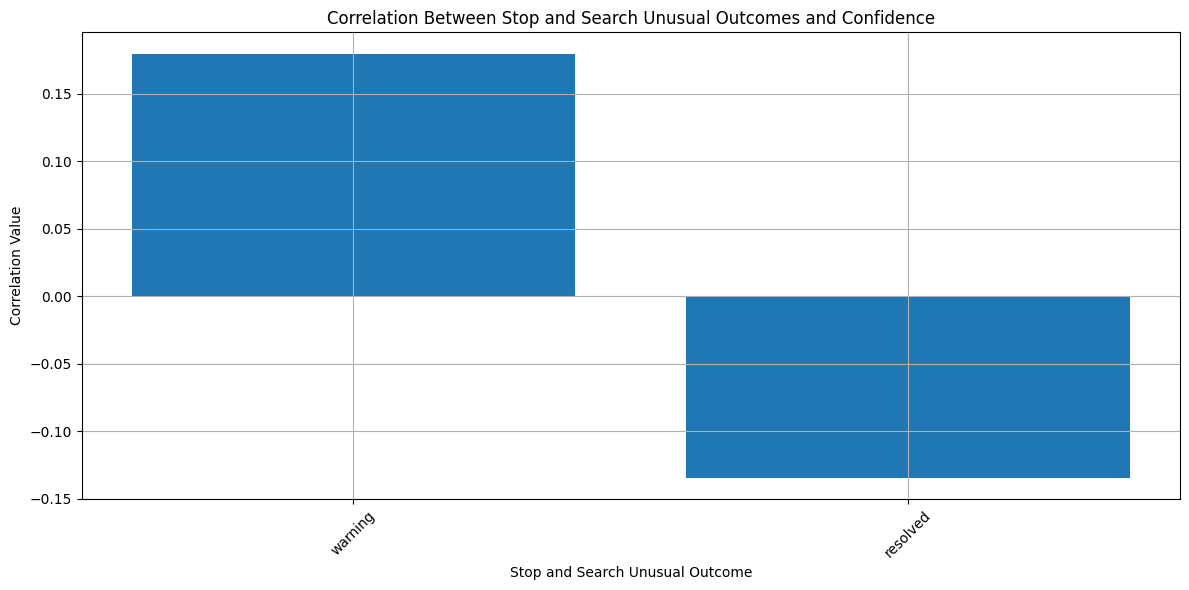

In [61]:
# Do the same for confidence

correlation_outcomes = stop_search_unusual_over_time_temp.corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Unusual Outcomes and Confidence')
plt.xlabel('Stop and Search Unusual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

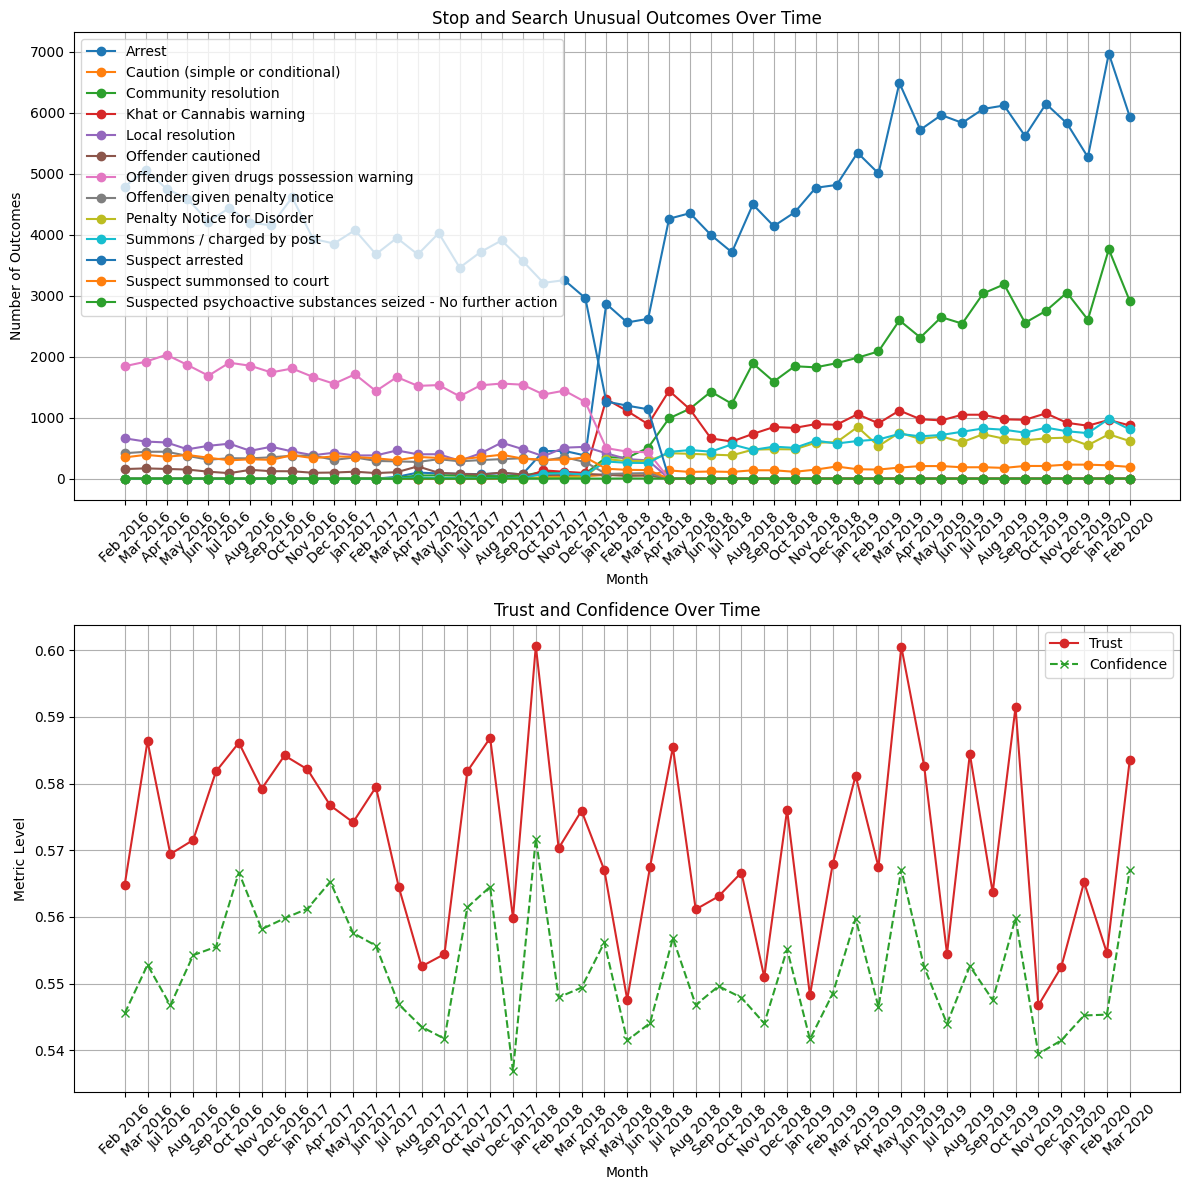

In [62]:
# Plot all unusual outcomes over time
# along with trust and confidence over time

stop_search_unusual_over_time = df_stop_search_unusual.groupby([pd.Grouper(key='Date', freq='M'), 'Outcome']).size().reset_index(name='Count')
stop_search_unusual_over_time = stop_search_unusual_over_time.pivot(index='Date', columns='Outcome', values='Count').reset_index()
stop_search_unusual_over_time = stop_search_unusual_over_time.fillna(0)
stop_search_unusual_over_time['Date'] = stop_search_unusual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in stop_search_unusual_over_time.columns[1:]:
    ax[0].plot(stop_search_unusual_over_time['Date'], stop_search_unusual_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Stop and Search Unusual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

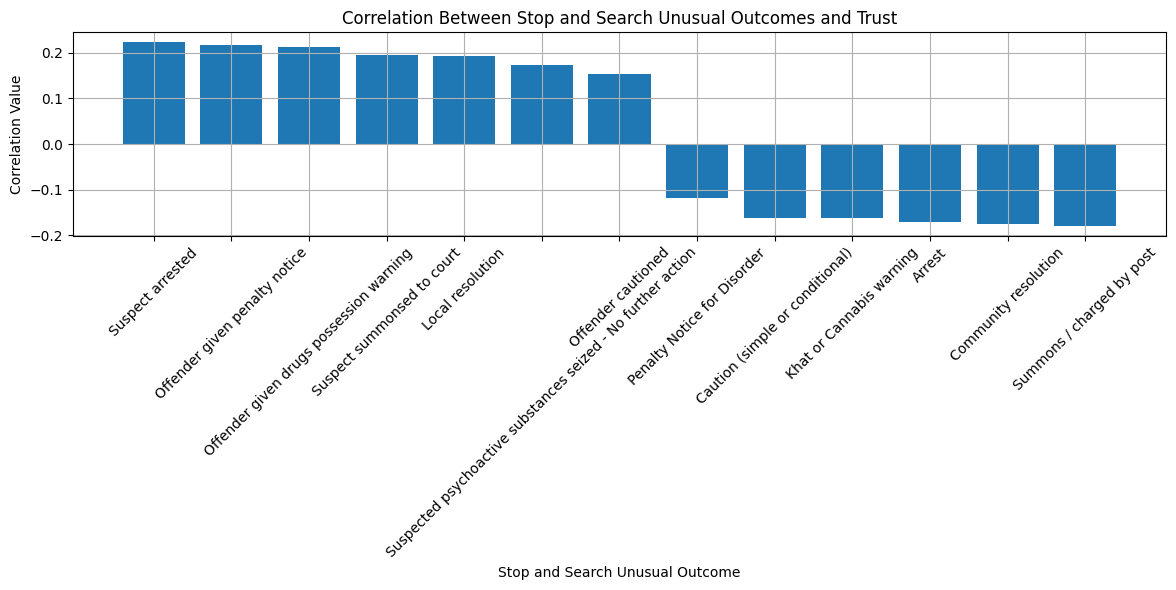

In [63]:
# Analyze correlations with each of the outcomes against trust and plot them in a bar chart

stop_search_unusual_over_time_temp = stop_search_unusual_over_time.drop(columns=['Date'])
correlation_outcomes = stop_search_unusual_over_time_temp.corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Unusual Outcomes and Trust')
plt.xlabel('Stop and Search Unusual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

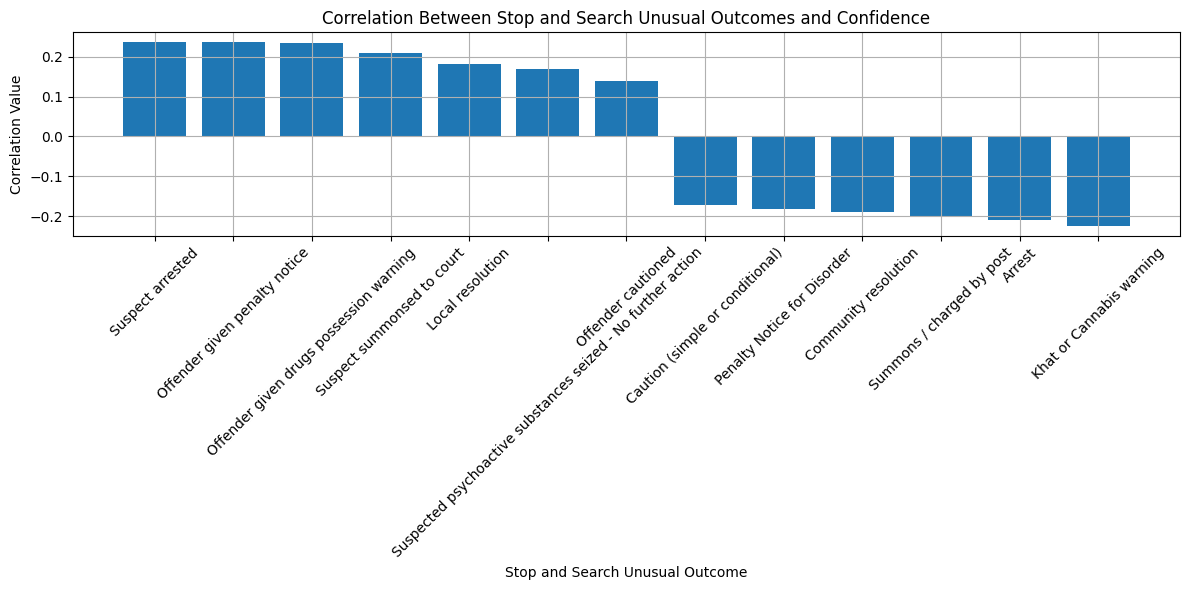

In [64]:
# Do the same for confidence

correlation_outcomes = stop_search_unusual_over_time_temp.corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Unusual Outcomes and Confidence')
plt.xlabel('Stop and Search Unusual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

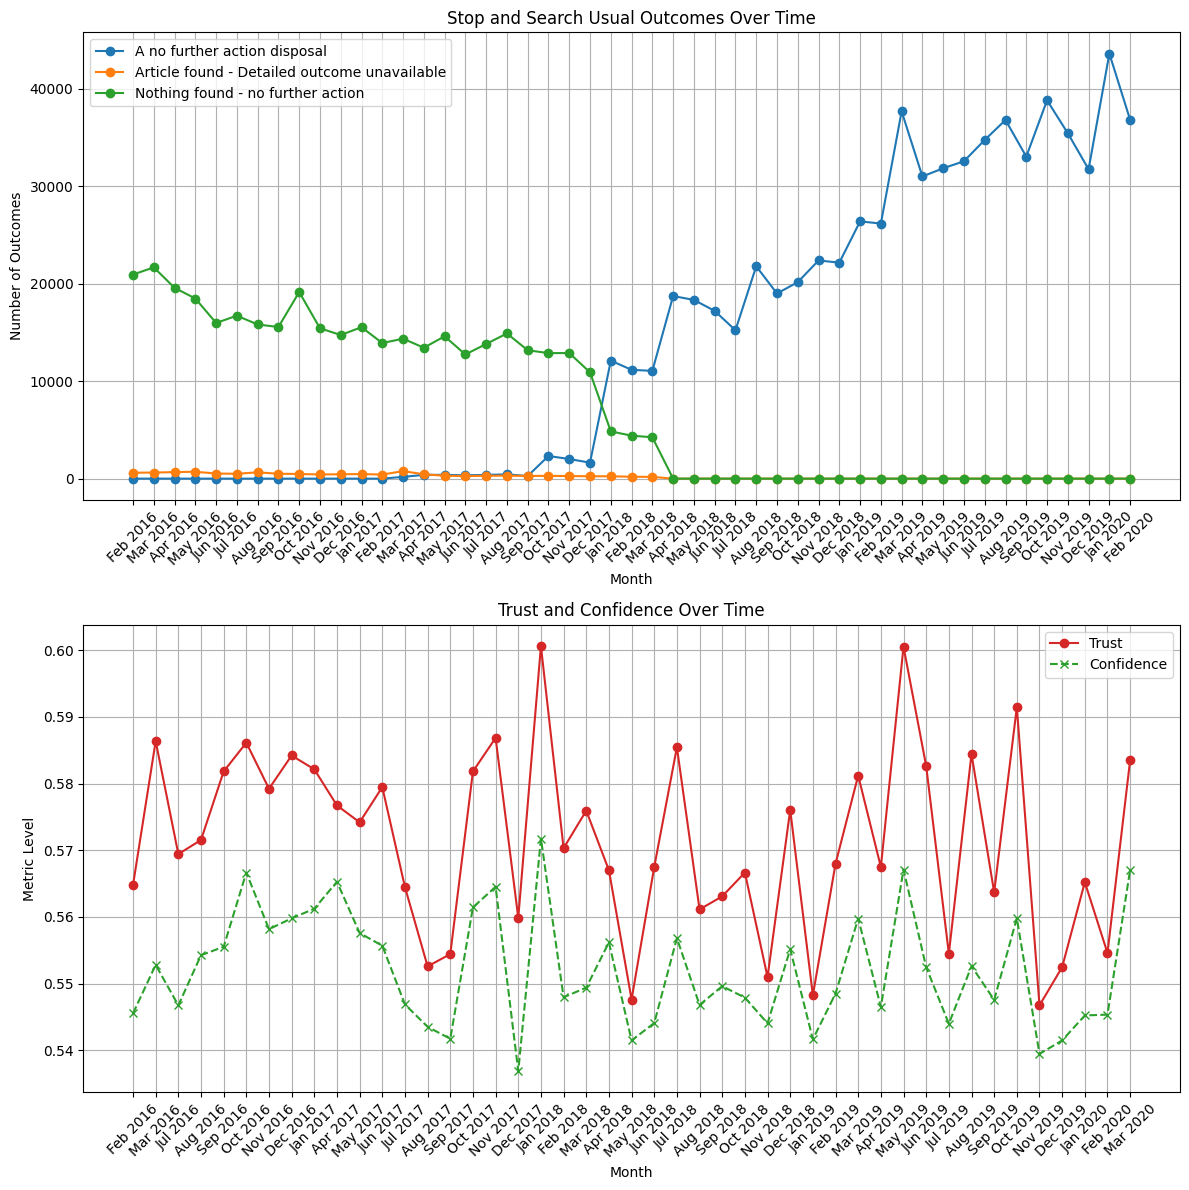

In [65]:
# Do the same for usual outcomes

stop_search_usual_over_time = df_stop_search_usual.groupby([pd.Grouper(key='Date', freq='M'), 'Outcome']).size().reset_index(name='Count')
stop_search_usual_over_time = stop_search_usual_over_time.pivot(index='Date', columns='Outcome', values='Count').reset_index()
stop_search_usual_over_time = stop_search_usual_over_time.fillna(0)
stop_search_usual_over_time['Date'] = stop_search_usual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in stop_search_usual_over_time.columns[1:]:
    ax[0].plot(stop_search_usual_over_time['Date'], stop_search_usual_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Stop and Search Usual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

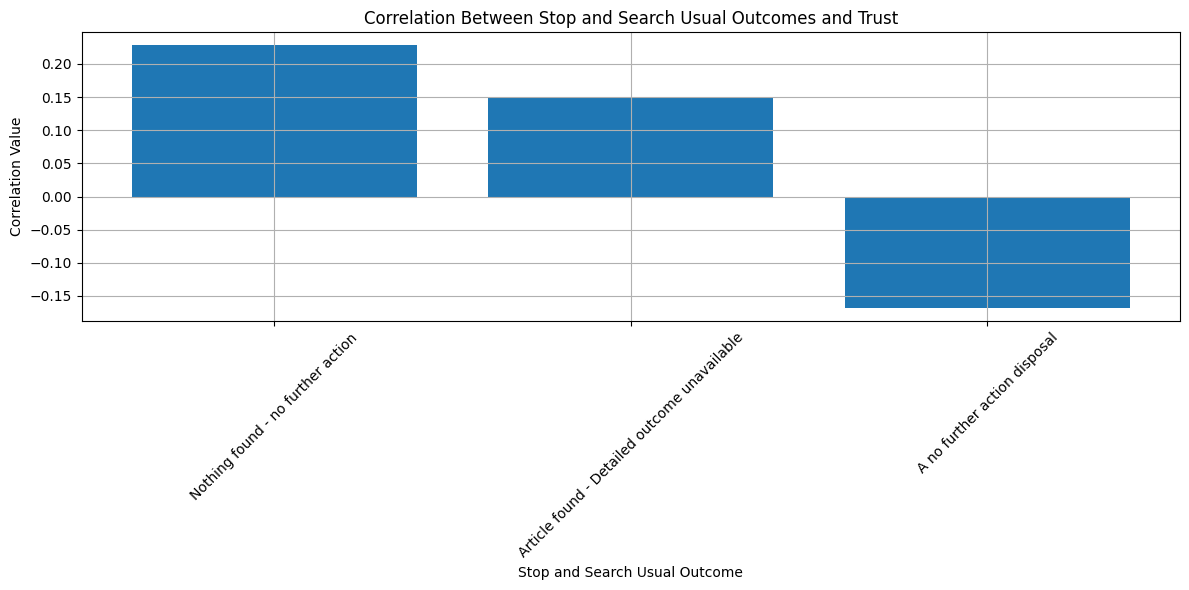

In [66]:
# Analyze correlations with each of the outcomes against trust and plot them in a bar chart

stop_search_usual_over_time_temp = stop_search_usual_over_time.drop(columns=['Date'])
correlation_outcomes = stop_search_usual_over_time_temp.corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Usual Outcomes and Trust')
plt.xlabel('Stop and Search Usual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

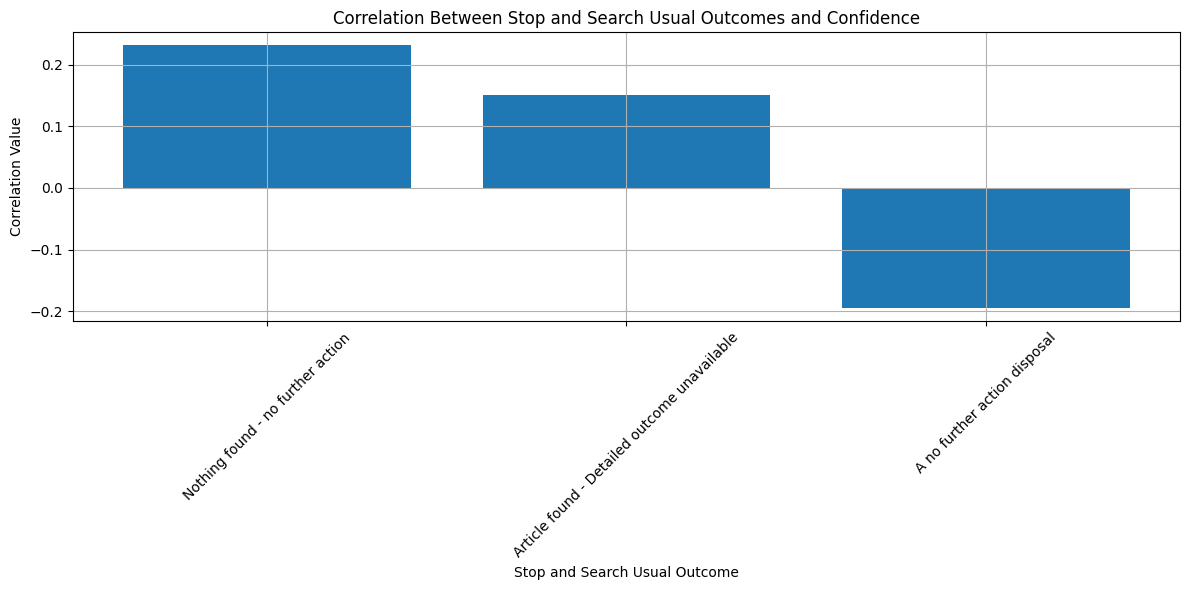

In [67]:
# Do the same for confidence

correlation_outcomes = stop_search_usual_over_time_temp.corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Stop and Search Usual Outcomes and Confidence')
plt.xlabel('Stop and Search Usual Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Combining data for modelling (later on)

In [151]:
unusual_cols = [f'SS_O_{col}' for col in stop_search_unusual_over_time.columns[1:]]
unusual_cols.insert(0, 'Date')

usual_cols = [f'SS_O_{col}' for col in stop_search_usual_over_time.columns[1:]]
usual_cols.insert(0, 'Date')

stop_search_unusual_over_time.columns = unusual_cols
stop_search_usual_over_time.columns = usual_cols

In [153]:
final_analysis_df = pd.merge(final_analysis_df, stop_search_usual_over_time, on='Date', how='inner')
final_analysis_df = pd.merge(final_analysis_df, stop_search_unusual_over_time, on='Date', how='inner')

## Analyzing use of force data

In [68]:
use_of_force = pd.read_csv('data/curated_data/curated_use_of_force.csv')

In [69]:
# columns in use of force df:

# "IncidentDate"
# "IncidentTime"
# "Incident Location: Street/Highway"
# "Incident Location: Public Transport"
# "Incident Location: Retail Premises"
# "Incident Location: Open ground (e.g. park, car park, field)"
# "Incident Location: Licensed Premises"
# "Incident Location: Sports or Event Stadia"
# "Incident Location: Hospital/A&E (non-mental-health setting)"
# "Incident Location: Mental Health Setting"
# "Incident Location: Police vehicle with prisoner handling cage"
# "Incident Location: Police vehicle without prisoner handling cage"
# "Incident Location: Dwelling"
# "Incident Location: Police station (excluding custody block)"
# "Incident Location: Custody Block"
# "Incident Location: Ambulance"
# "Incident Location: Other"
# "Borough"
# "PrimaryConduct"
# "AssaultedBySubject"
# "ThreatenedWithWeapon"
# "AssaultedWithWeapon"
# "Impact Factor: Possesion of a weapon"
# "Impact Factor: Alcohol"
# "Impact Factor: Drugs"
# "Impact Factor: Mental Health"
# "Impact Factor: Prior Knowledge"
# "Impact Factor: Size/Gender/Build"
# "Impact Factor: Acute Behavioural Disorder"
# "Impact Factor: Crowd"
# "Impact Factor: Other"
# "Reason for Force: Protect self"
# "Reason for Force: Protect Public"
# "Reason for Force: Protect Subject"
# "Reason for Force: Protect Other Officers"
# "Reason for Force: Prevent Offence"
# "Reason for Force: Secure Evidence"
# "Reason for Force: Effect Search"
# "Reason for Force: Effect Arrest"
# "Reason for Force: Method of Entry"
# "Reason for Force: Remove Handcuffs"
# "Reason for Force: Prevent Harm"
# "Reason for Force: Prevent Escape"
# "Reason for Force: Other"
# "MainDuty"
# "Firearms Aimed"
# "Firearms Fired"
# "SubjectAge"
# "SubjectGender"
# "SubjectEthnicity"
# "PhysicalDisability"
# "MentalDisability"
# "StaffInjured"
# "StaffInjuryIntentional"
# "StaffInjuryLevel"
# "StaffMedProvided"
# "SubjectInjured"
# "SubjectMedOffered"
# "SubjectMedProvided"
# "Outcome: Made off/escaped"
# "Outcome: Arrested"
# "Outcome: Hospitalised"
# "Outcome: Detained - Mental Health Act"
# "Outcome: Fatality"
# "Outcome: Other"

In [70]:
use_of_force = use_of_force.rename(columns={'IncidentDate': 'Date'})

# now convert to datetime using format '4/1/2017'
use_of_force['Date'] = pd.to_datetime(use_of_force['Date'], format='mixed')

use_of_force.replace('No', 0, inplace=True)
use_of_force.replace('Yes', 1, inplace=True)

In [71]:
# analyze outcomes of use of force
use_of_force_outcomes = use_of_force[[
        "Date", "IncidentTime",
        "Outcome: Made off/escaped", "Outcome: Arrested", "Outcome: Hospitalised", "Outcome: Detained - Mental Health Act", "Outcome: Fatality", "Outcome: Other"
    ]]

# This is to make sure that every row is a unique incident
use_of_force_outcomes = use_of_force_outcomes.groupby(['Date', 'IncidentTime']).max().reset_index()

# This is to get a count of incidents per DAY
use_of_force_outcomes = use_of_force_outcomes.groupby('Date').sum().reset_index()

# Reformat Datetime
use_of_force_outcomes['Date'] = pd.to_datetime(use_of_force_outcomes['Date'], format='%Y-%m-%d')

# Limit date ranges (Feb 2016 to March 2020)
use_of_force_outcomes = use_of_force_outcomes[use_of_force_outcomes['Date'] < '2020-03-31']

# This is to get a count of incidents by month
use_of_force_outcomes = use_of_force_outcomes.groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

# reformat datetime
use_of_force_outcomes['Date'] = use_of_force_outcomes['Date'].dt.strftime('%b %Y')

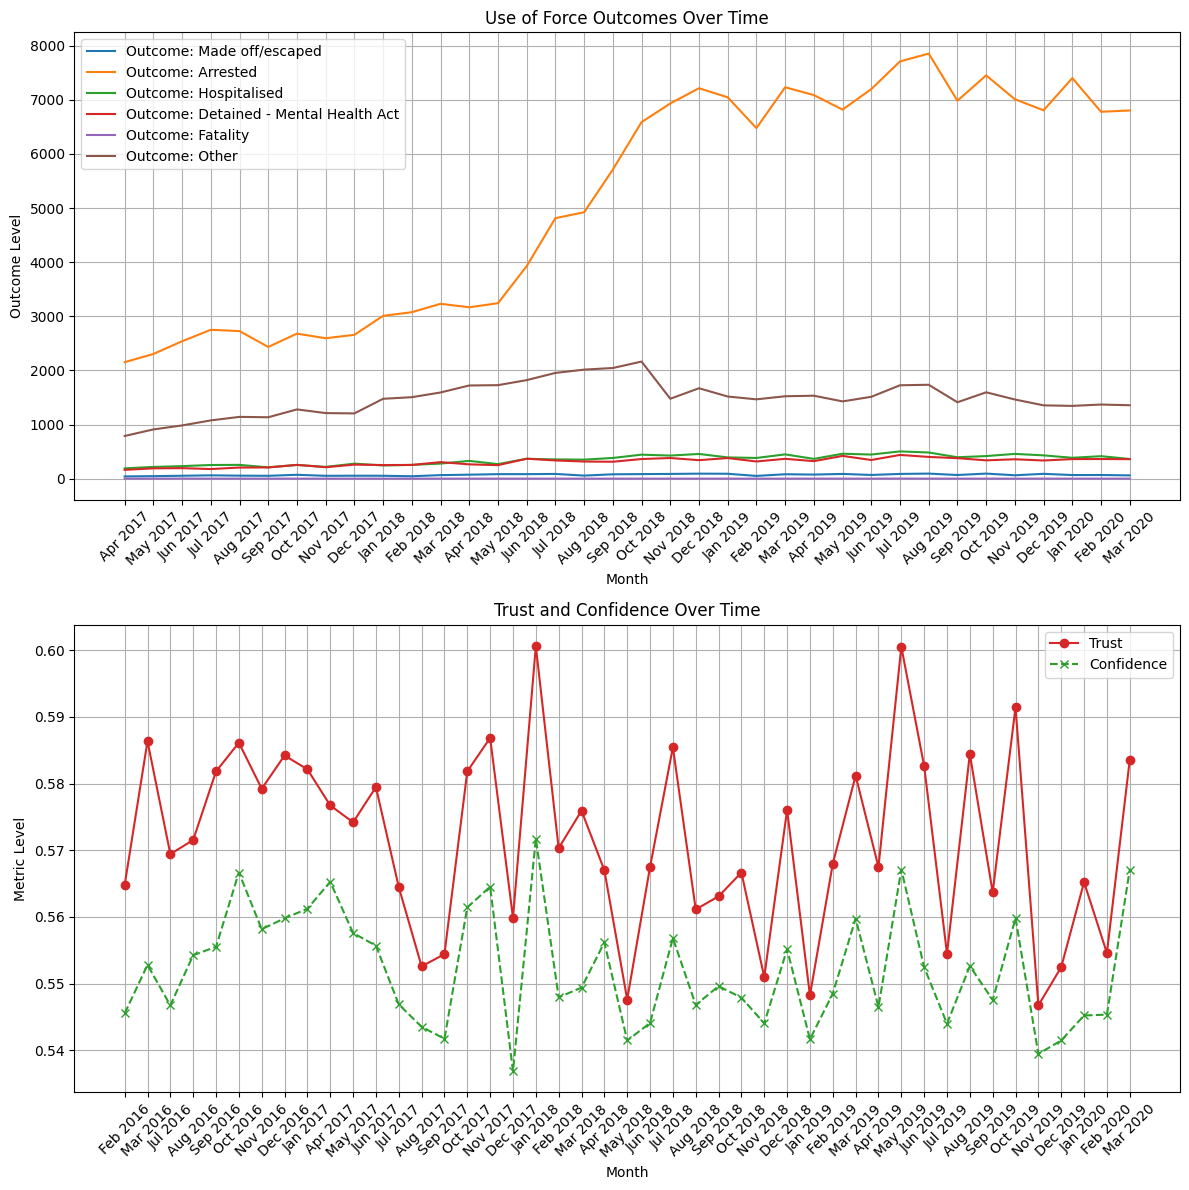

In [72]:
# plot use of force outcome types against trust and confidence

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in use_of_force_outcomes.columns[2:]:
    ax[0].plot(use_of_force_outcomes['Date'], use_of_force_outcomes[col], linestyle='-', label=col)

ax[0].set_title('Use of Force Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Outcome Level')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Trust'], color='tab:red', marker='o', linestyle='-', label='Trust')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Confidence'], color='tab:green', marker='x', linestyle='--', label='Confidence')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

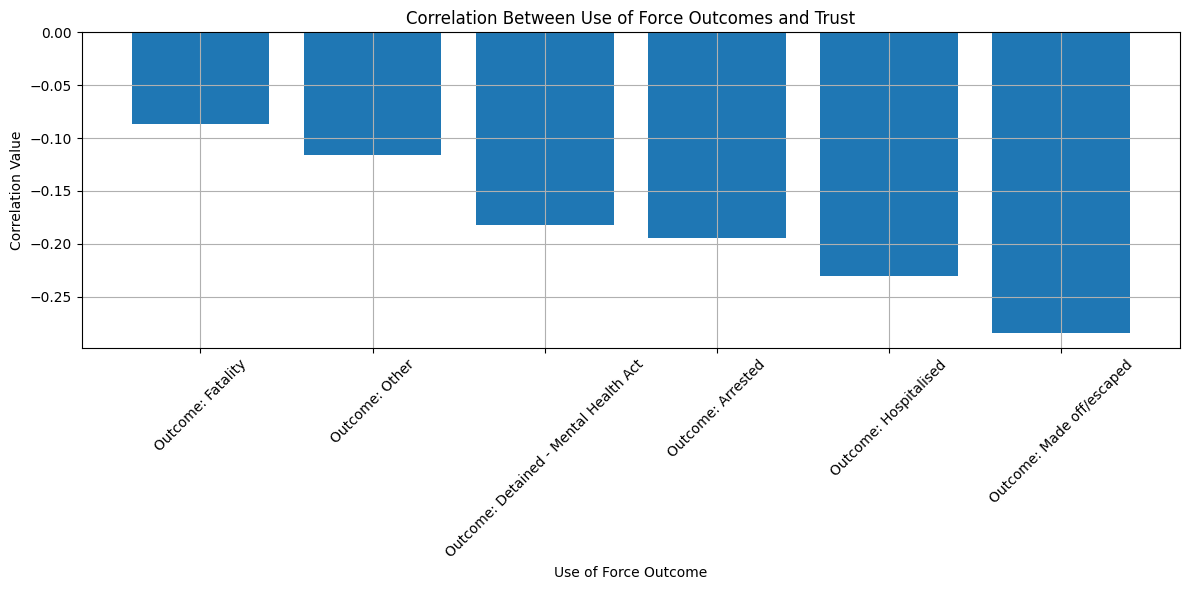

In [73]:
# Calculate correlations between use of force outcomes and trust and confidence
# and plot them in a bar chart

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Trust']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Trust Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Trust Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Trust Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Trust')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


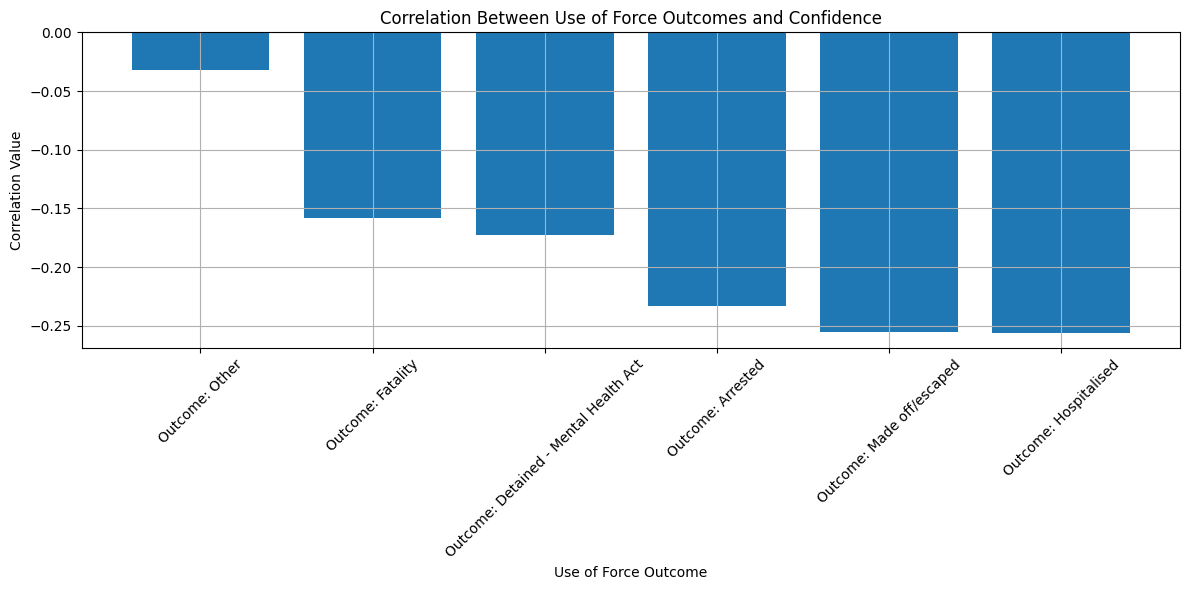

In [74]:
# do the same for confidence

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Confidence']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Confidence')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

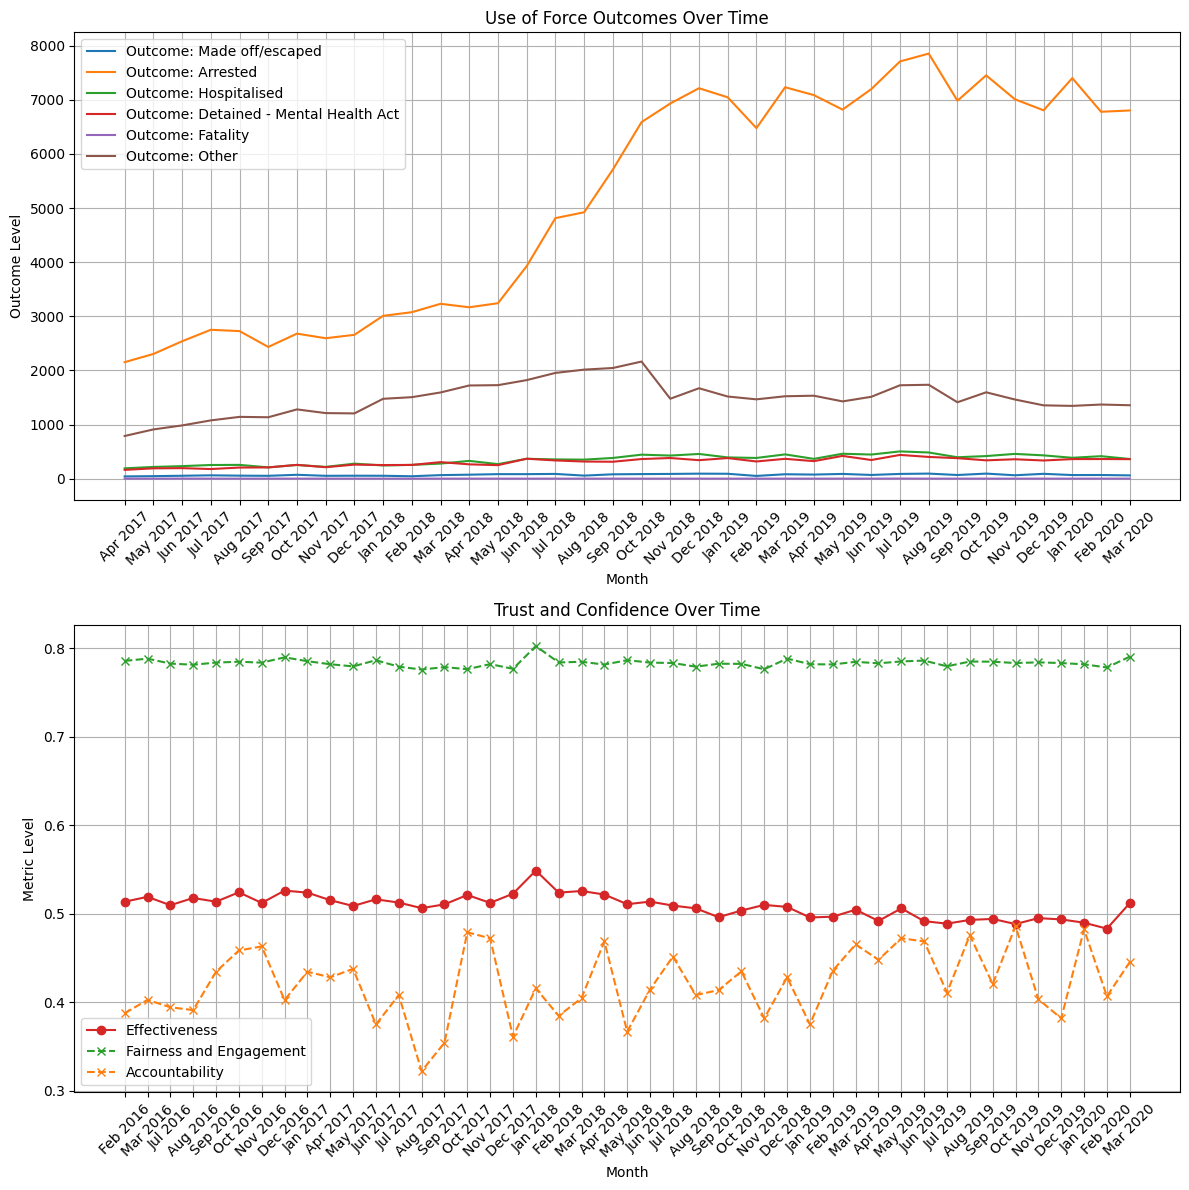

In [75]:
# Instead of trust and confidence, plot use of force outcomes against effectiveness, fairness and engagement, accountability, and trust

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in use_of_force_outcomes.columns[2:]:
    ax[0].plot(use_of_force_outcomes['Date'], use_of_force_outcomes[col], linestyle='-', label=col)

ax[0].set_title('Use of Force Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Outcome Level')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Effectiveness'], color='tab:red', marker='o', linestyle='-', label='Effectiveness')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Fairness and Engagement'], color='tab:green', marker='x', linestyle='--', label='Fairness and Engagement')
ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped['Accountability'], color='tab:orange', marker='x', linestyle='--', label='Accountability')
ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

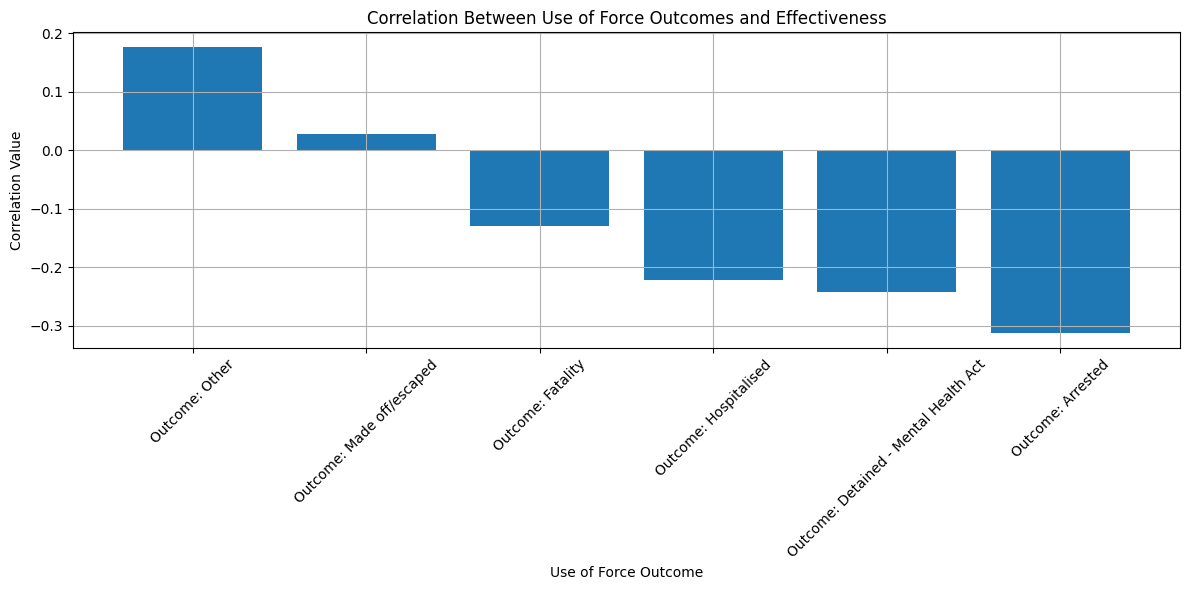

In [76]:
# analyze correlations between each of the categories ('Effectiveness', 'Fairness and Engagement', and 'Accountability', and 'Confidence Questions') and use of force outcomes
# create a bar chart for each of the categories

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Effectiveness']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Effectiveness Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Effectiveness Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Effectiveness Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Effectiveness')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

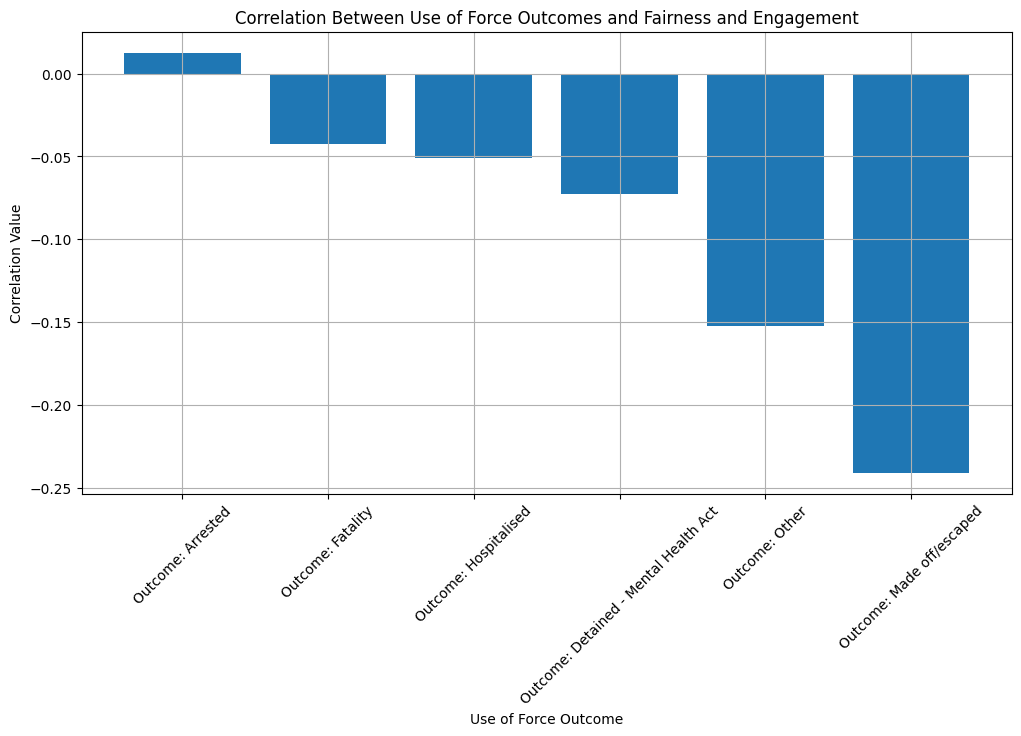

In [77]:
# do the same for fairness and engagement

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Fairness and Engagement']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Fairness and Engagement Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Fairness and Engagement Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Fairness and Engagement Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Fairness and Engagement')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)

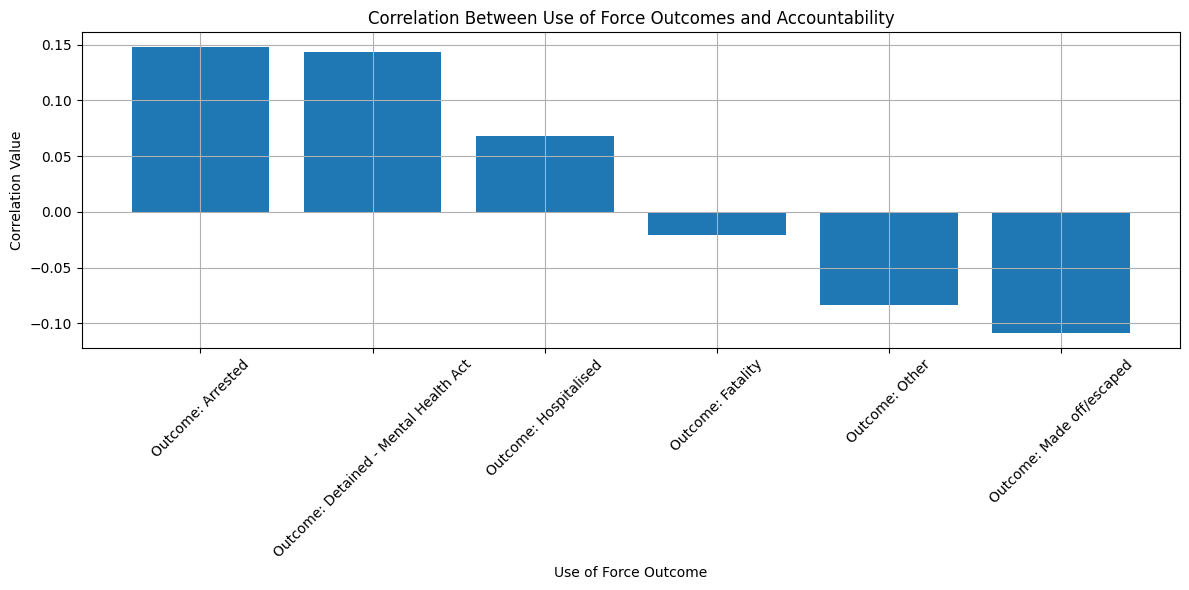

In [78]:
# do the same for accountability

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Accountability']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Accountability Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Accountability Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Accountability Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Accountability')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

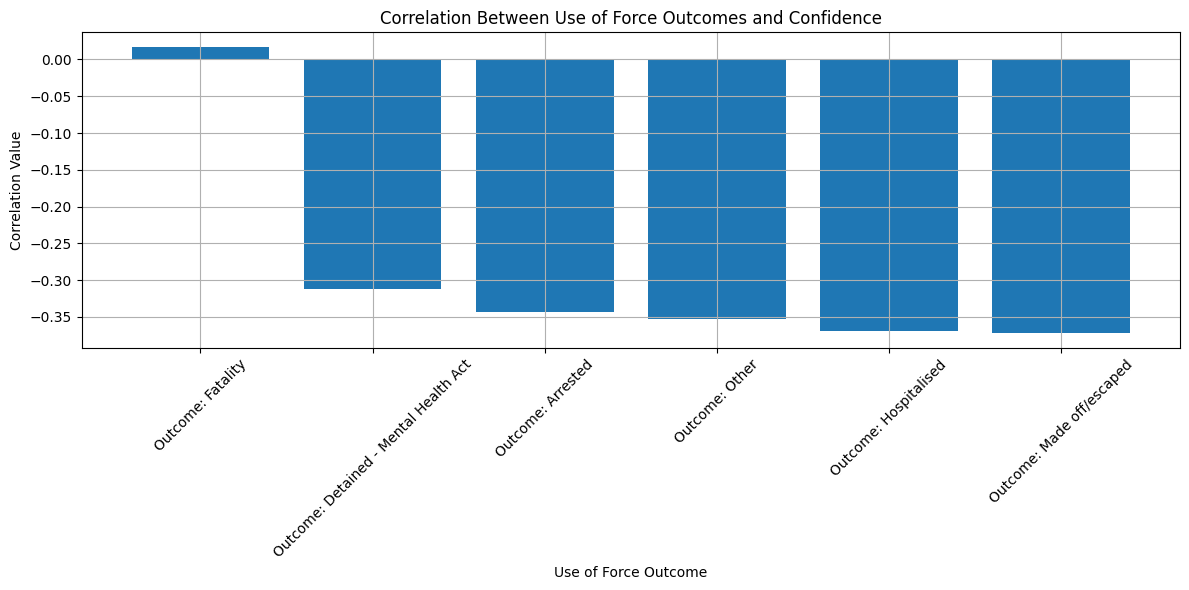

In [79]:
# do the same for confidence questions

correlation_outcomes = use_of_force_outcomes.drop(['Date', 'IncidentTime'], axis=1).corrwith(trust_conf_grouped['Confidence Questions']).reset_index()
correlation_outcomes.columns = ['Outcome', 'Confidence Correlation']
correlation_outcomes = correlation_outcomes.sort_values('Confidence Correlation', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(correlation_outcomes['Outcome'], correlation_outcomes['Confidence Correlation'], color='tab:blue')
plt.title('Correlation Between Use of Force Outcomes and Confidence')
plt.xlabel('Use of Force Outcome')
plt.ylabel('Correlation Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyzing impact and correlations directly to questions

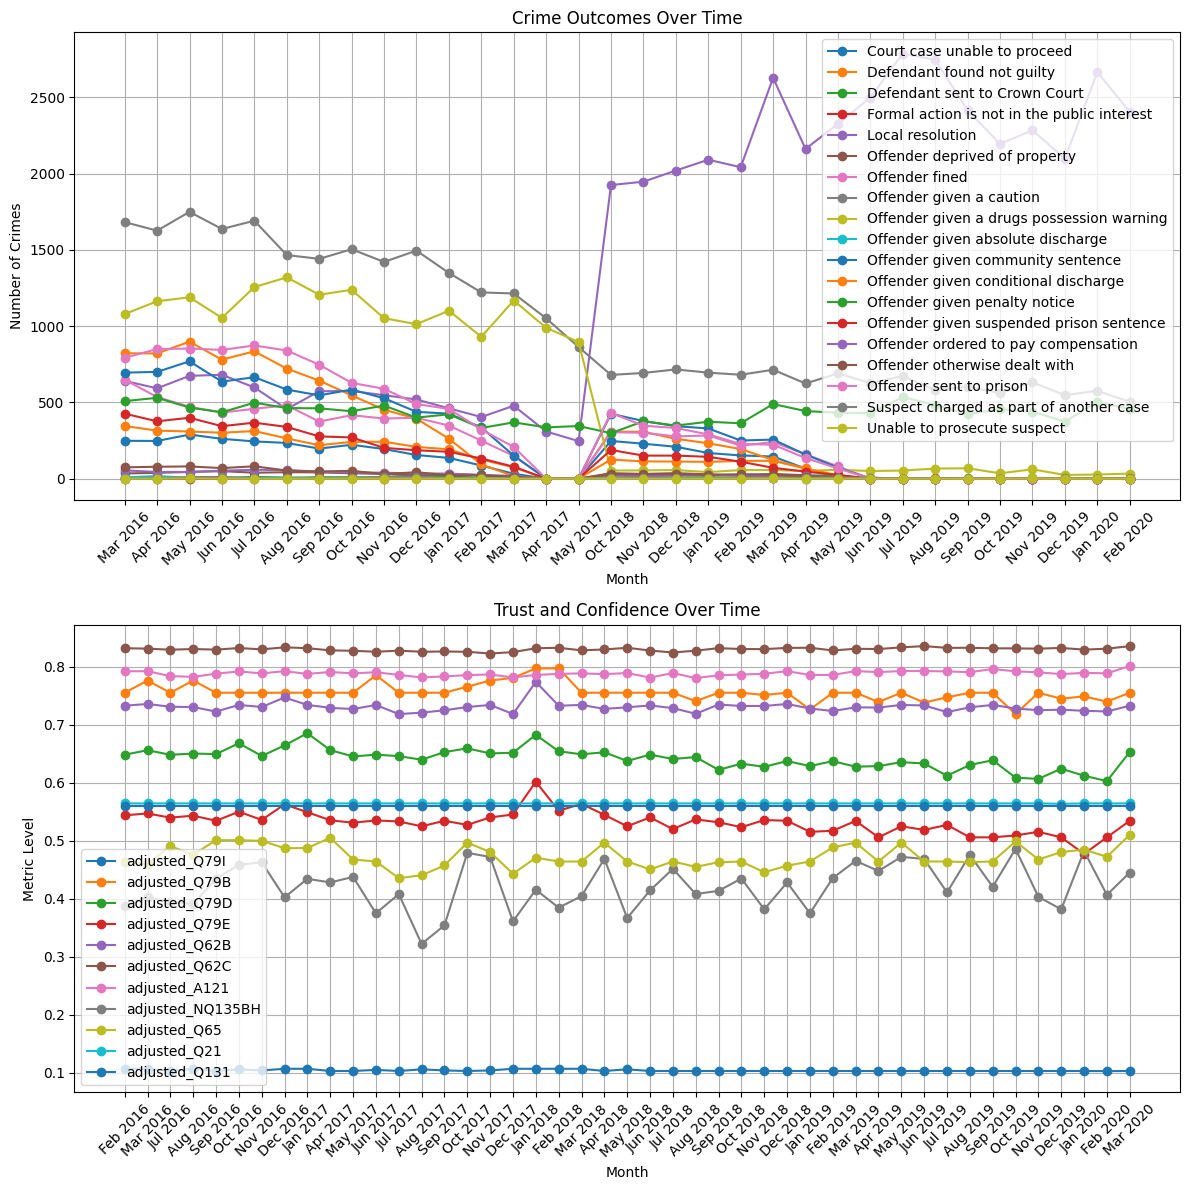

In [80]:
# Perform all the above analyses for the (i.e, analyze crimes and crime outcomes, stop and search, and use of force data) but instead of trust and confidence, use the other metrics (inividual questions in the survey, defined in variable 'questions_adjusted', which are columns in the trust_conf_grouped dataframe)

# crimes and crime outcomes
outcomes_over_time = crimes.groupby(['Month', 'Last outcome category']).size().reset_index(name='Count')
outcomes_over_time = outcomes_over_time.pivot(index='Month', columns='Last outcome category', values='Count').reset_index()
outcomes_over_time = outcomes_over_time.fillna(0)
outcomes_over_time['Month'] = pd.to_datetime(outcomes_over_time['Month'], format='%Y-%m')
outcomes_over_time = outcomes_over_time[(outcomes_over_time['Month'] > '2016-02-01') & (outcomes_over_time['Month'] < '2020-03-01')]
outcomes_over_time['Month'] = outcomes_over_time['Month'].dt.strftime('%b %Y')

outcomes_over_time = outcomes_over_time.drop(columns=['Investigation complete; no suspect identified'])
outcomes_over_time = outcomes_over_time.drop(columns=['Status update unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Court result unavailable'])
outcomes_over_time = outcomes_over_time.drop(columns=['Awaiting court outcome'])
outcomes_over_time = outcomes_over_time.drop(columns=['Under investigation'])

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in outcomes_over_time.columns[1:]:
    ax[0].plot(outcomes_over_time['Month'], outcomes_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Crime Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Crimes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

for col in questions_adjusted:
    ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped[col], marker='o', linestyle='-', label=col)

ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

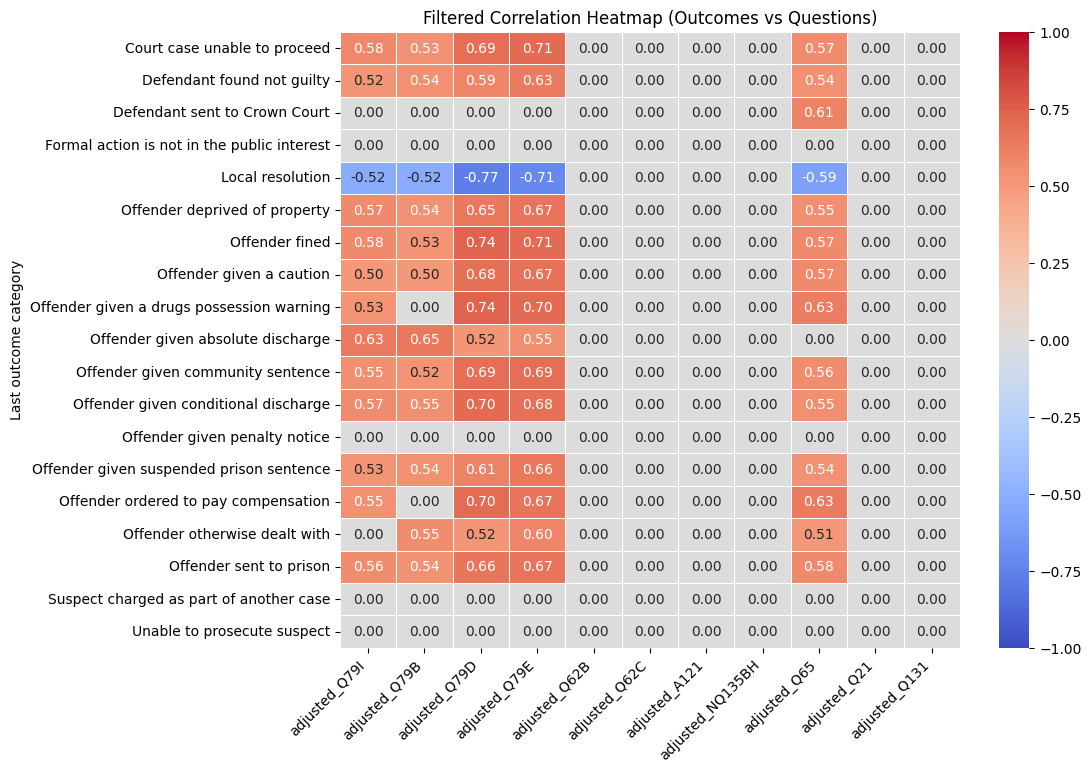

In [81]:
# calculate correlations between each of the adjusted questions and the crime outcomes and plot heatmap (merge dataframes and use corr() method

dates = list(outcomes_over_time['Month'].value_counts().keys())
temp_trust_conf_grouped = trust_conf_grouped[trust_conf_grouped['Date'].isin(dates)]
temp_trust_conf_grouped = temp_trust_conf_grouped.drop(columns=['Date'])
temp_trust_conf_grouped = temp_trust_conf_grouped[questions_adjusted]

temp_outcomes_over_time = outcomes_over_time.drop(columns=['Month'])
correlation_df = pd.concat([temp_outcomes_over_time, temp_trust_conf_grouped], axis=1)
correlation_matrix = correlation_df.corr()

# Filter correlations
# filtered_correlation = correlation_matrix[(correlation_matrix > 0.60) | (correlation_matrix < -0.60)].fillna(0)
filtered_correlation = correlation_matrix[(correlation_matrix > 0.50) | (correlation_matrix < -0.50)].fillna(0)

# Redefine outcome_indices and question_indices to be column names instead of indices
outcome_columns = temp_outcomes_over_time.columns
question_columns = temp_trust_conf_grouped.columns

# Create a new DataFrame to only include the correlations between outcomes and questions
correlation_subset = filtered_correlation.loc[outcome_columns, question_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Filtered Correlation Heatmap (Outcomes vs Questions)')
plt.show()

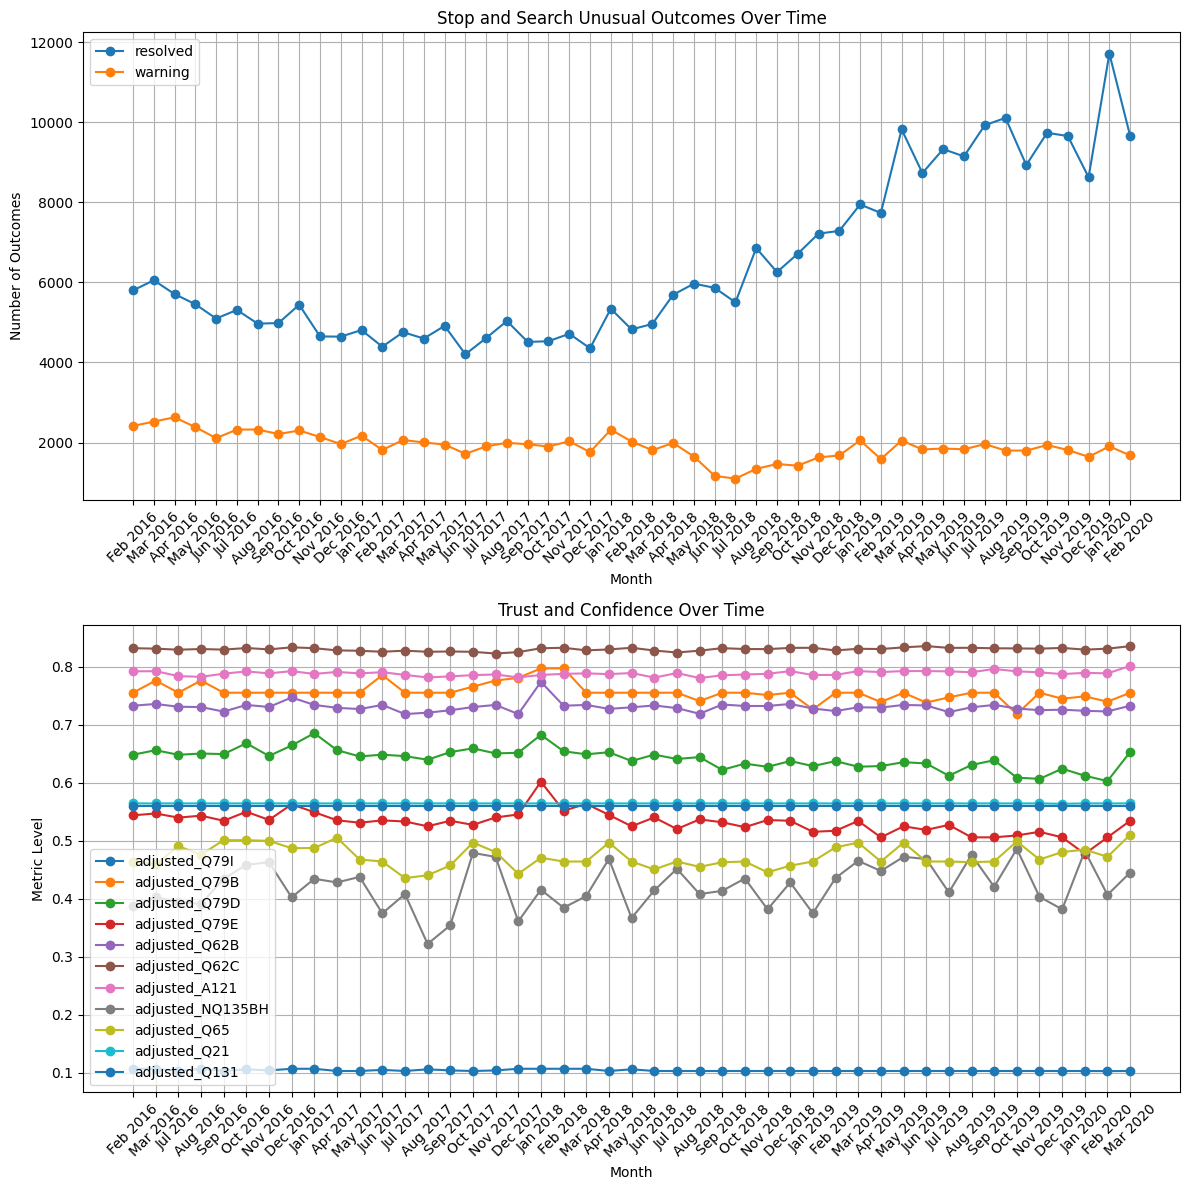

In [82]:
# Do the same for stop and search unusual outcomes and the adjusted questions

stop_search_unusual_over_time = df_stop_search_unusual.groupby([pd.Grouper(key='Date', freq='M'), 'Mapped_Outcomes']).size().reset_index(name='Count')
stop_search_unusual_over_time = stop_search_unusual_over_time.pivot(index='Date', columns='Mapped_Outcomes', values='Count').reset_index()
stop_search_unusual_over_time = stop_search_unusual_over_time.fillna(0)
stop_search_unusual_over_time['Date'] = stop_search_unusual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in stop_search_unusual_over_time.columns[1:]:
    ax[0].plot(stop_search_unusual_over_time['Date'], stop_search_unusual_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Stop and Search Unusual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

for col in questions_adjusted:
    ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped[col], marker='o', linestyle='-', label=col)

ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

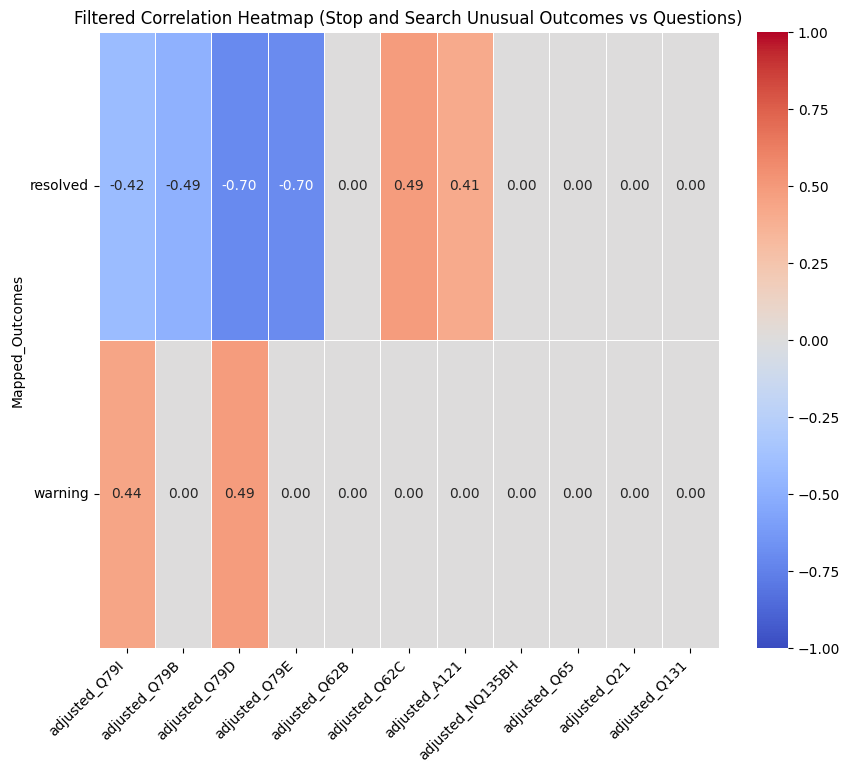

In [83]:
# Get the correlation between unusual stop and search outcomes and the adjusted questions
# and plot the heatmap

dates = list(stop_search_unusual_over_time['Date'].value_counts().keys())
temp_trust_conf_grouped = trust_conf_grouped[trust_conf_grouped['Date'].isin(dates)]
temp_trust_conf_grouped = temp_trust_conf_grouped.drop(columns=['Date'])
temp_trust_conf_grouped = temp_trust_conf_grouped[questions_adjusted]

temp_stop_search_unusual_over_time = stop_search_unusual_over_time.drop(columns=['Date'])
correlation_df = pd.concat([temp_stop_search_unusual_over_time, temp_trust_conf_grouped], axis=1)
correlation_matrix = correlation_df.corr()

# Filter correlations
# filtered_correlation = correlation_matrix[(correlation_matrix > 0.60) | (correlation_matrix < -0.60)].fillna(0)
filtered_correlation = correlation_matrix[(correlation_matrix > 0.40) | (correlation_matrix < -0.40)].fillna(0)

# Redefine outcome_indices and question_indices to be column names instead of indices
outcome_columns = temp_stop_search_unusual_over_time.columns
question_columns = temp_trust_conf_grouped.columns

# Create a new DataFrame to only include the correlations between outcomes and questions
correlation_subset = filtered_correlation.loc[outcome_columns, question_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Filtered Correlation Heatmap (Stop and Search Unusual Outcomes vs Questions)')
plt.show()

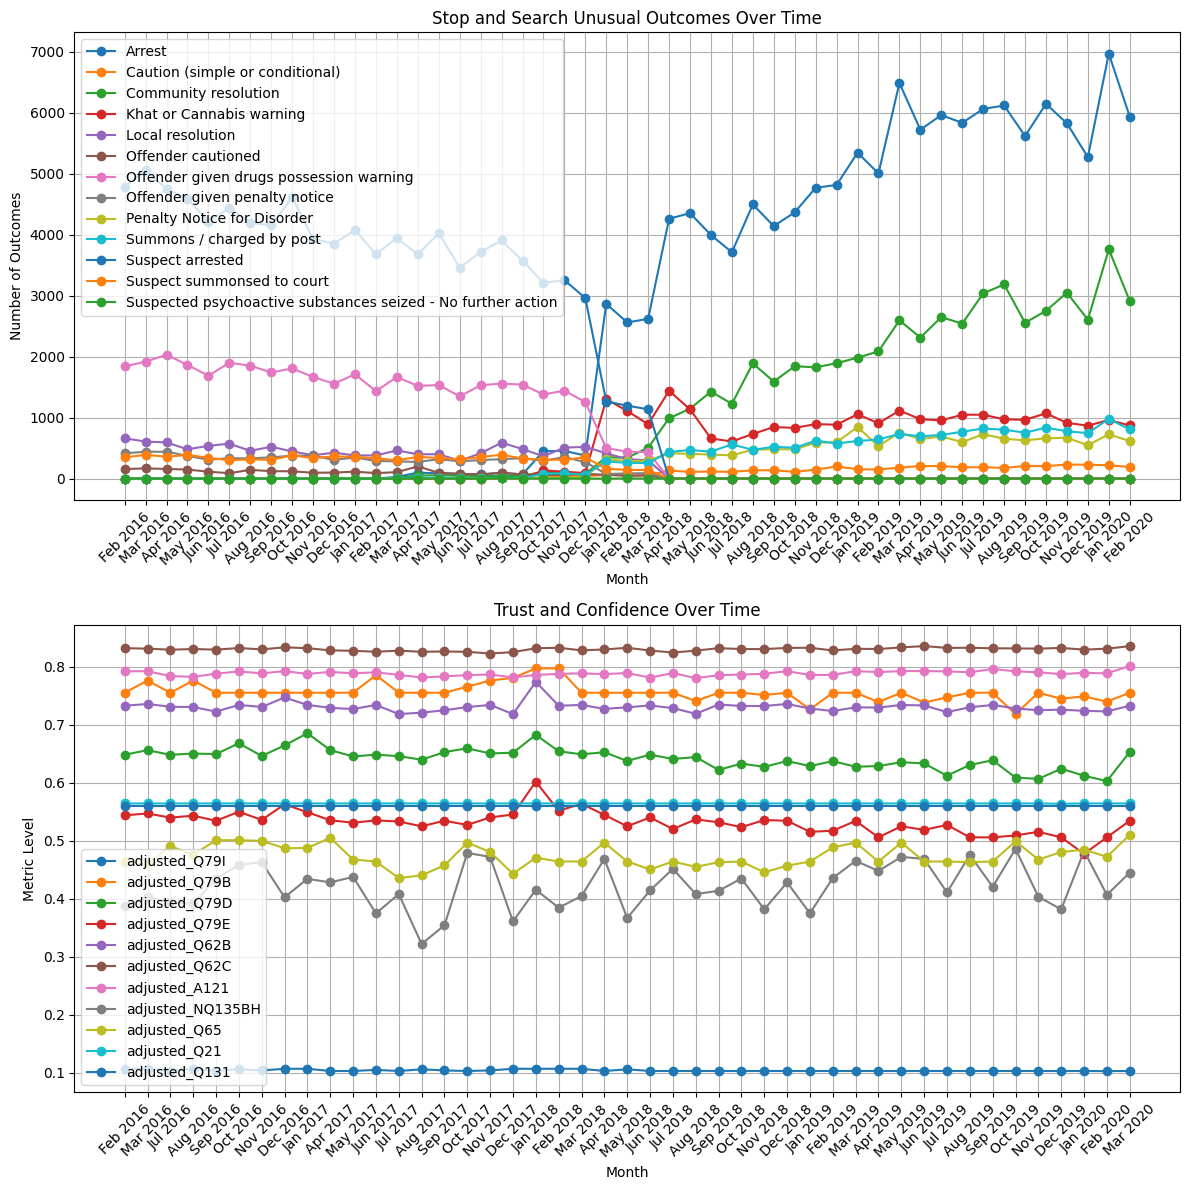

In [84]:
# Now do this for all resolved stop and search outcomes (unusual outcomes)
# and the adjusted questions

stop_search_unusual_over_time = df_stop_search_unusual.groupby([pd.Grouper(key='Date', freq='M'), 'Outcome']).size().reset_index(name='Count')
stop_search_unusual_over_time = stop_search_unusual_over_time.pivot(index='Date', columns='Outcome', values='Count').reset_index()
stop_search_unusual_over_time = stop_search_unusual_over_time.fillna(0)
stop_search_unusual_over_time['Date'] = stop_search_unusual_over_time['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in stop_search_unusual_over_time.columns[1:]:
    ax[0].plot(stop_search_unusual_over_time['Date'], stop_search_unusual_over_time[col], marker='o', linestyle='-', label=col)

ax[0].set_title('Stop and Search Unusual Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Outcomes')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

for col in questions_adjusted:
    ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped[col], marker='o', linestyle='-', label=col)

ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

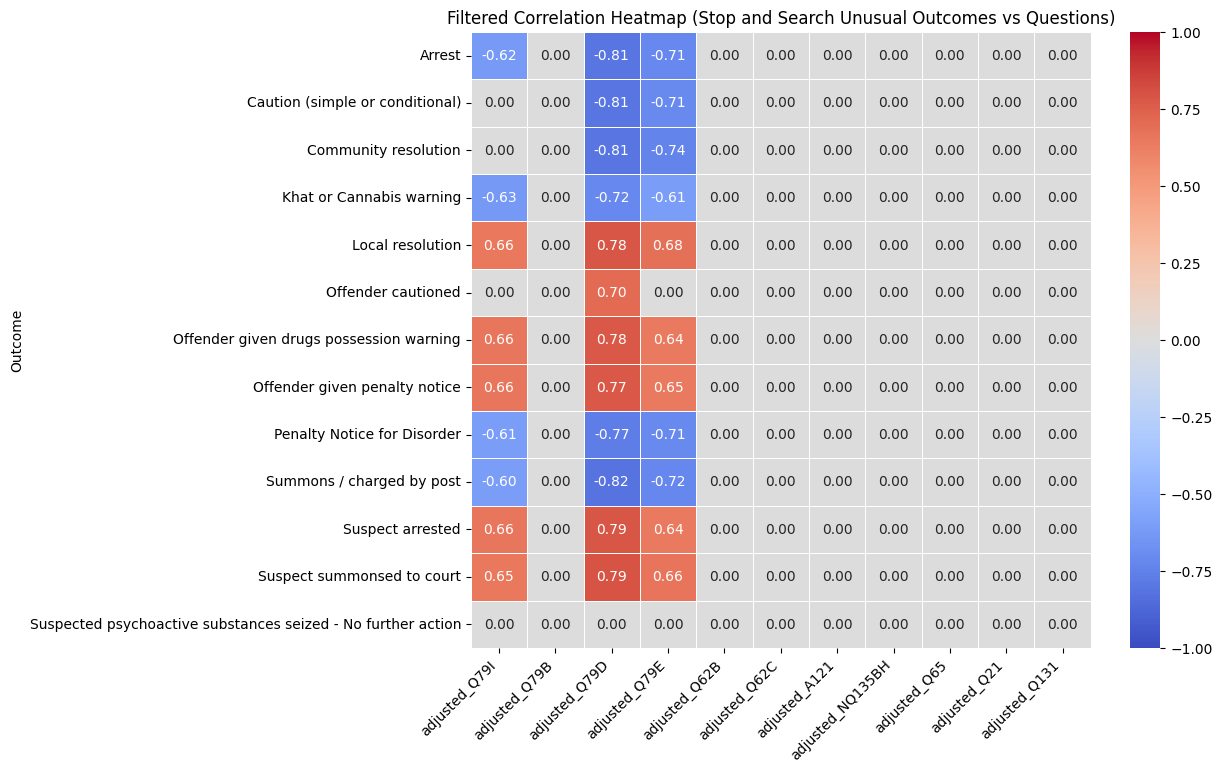

In [85]:
# Now get the correlation between all resolved stop and search outcomes and the adjusted questions
# and plot the heatmap

dates = list(stop_search_unusual_over_time['Date'].value_counts().keys())
temp_trust_conf_grouped = trust_conf_grouped[trust_conf_grouped['Date'].isin(dates)]
temp_trust_conf_grouped = temp_trust_conf_grouped.drop(columns=['Date'])
temp_trust_conf_grouped = temp_trust_conf_grouped[questions_adjusted]

temp_stop_search_unusual_over_time = stop_search_unusual_over_time.drop(columns=['Date'])
correlation_df = pd.concat([temp_stop_search_unusual_over_time, temp_trust_conf_grouped], axis=1)
correlation_matrix = correlation_df.corr()

# Filter correlations
filtered_correlation = correlation_matrix[(correlation_matrix > 0.60) | (correlation_matrix < -0.60)].fillna(0)
# filtered_correlation = correlation_matrix[(correlation_matrix > 0.40) | (correlation_matrix < -0.40)].fillna(0)

# Redefine outcome_indices and question_indices to be column names instead of indices
outcome_columns = temp_stop_search_unusual_over_time.columns
question_columns = temp_trust_conf_grouped.columns

# Create a new DataFrame to only include the correlations between outcomes and questions
correlation_subset = filtered_correlation.loc[outcome_columns, question_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Filtered Correlation Heatmap (Stop and Search Unusual Outcomes vs Questions)')
plt.show()

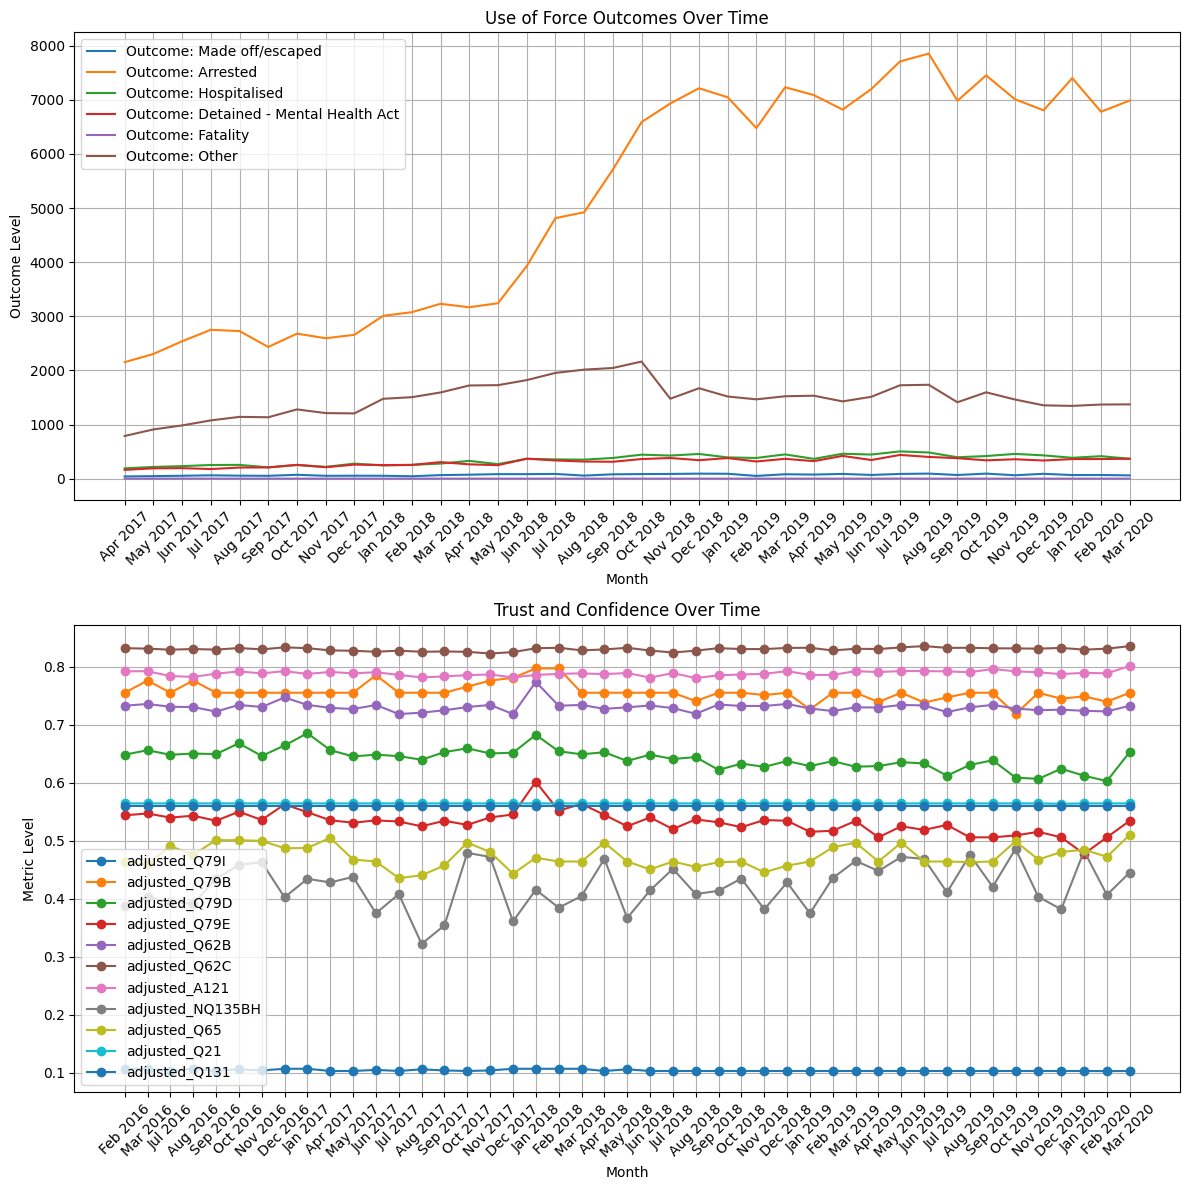

In [86]:
# Now do the same for use of force outcomes and the adjusted questions

use_of_force_outcomes = use_of_force[[
        "Date", "IncidentTime",
        "Outcome: Made off/escaped", "Outcome: Arrested", "Outcome: Hospitalised", "Outcome: Detained - Mental Health Act", "Outcome: Fatality", "Outcome: Other"
    ]]
use_of_force_outcomes = use_of_force_outcomes.groupby(['Date', 'IncidentTime']).max().reset_index()
use_of_force_outcomes = use_of_force_outcomes.groupby('Date').sum().reset_index()
use_of_force_outcomes = use_of_force_outcomes.groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()
use_of_force_outcomes['Date'] = use_of_force_outcomes['Date'].dt.strftime('%b %Y')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
for col in use_of_force_outcomes.columns[2:]:
    ax[0].plot(use_of_force_outcomes['Date'], use_of_force_outcomes[col], linestyle='-', label=col)

ax[0].set_title('Use of Force Outcomes Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Outcome Level')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

for col in questions_adjusted:
    ax[1].plot(trust_conf_grouped['Date'], trust_conf_grouped[col], marker='o', linestyle='-', label=col)

ax[1].set_title('Trust and Confidence Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Metric Level')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

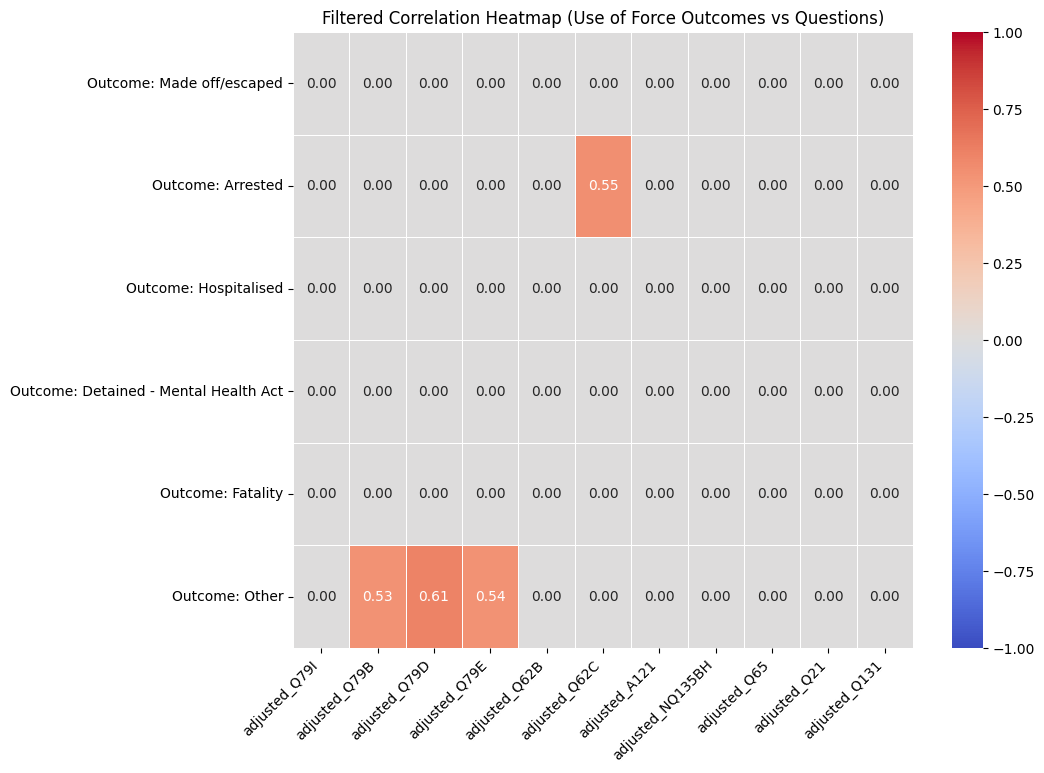

In [87]:
# Now get the correlation between use of force outcomes and the adjusted questions

dates = list(use_of_force_outcomes['Date'].value_counts().keys())
temp_trust_conf_grouped = trust_conf_grouped[trust_conf_grouped['Date'].isin(dates)]
temp_trust_conf_grouped = temp_trust_conf_grouped.drop(columns=['Date'])
temp_trust_conf_grouped = temp_trust_conf_grouped[questions_adjusted]

temp_use_of_force_outcomes = use_of_force_outcomes.drop(columns=['Date', 'IncidentTime'])
correlation_df = pd.concat([temp_use_of_force_outcomes, temp_trust_conf_grouped], axis=1)
correlation_matrix = correlation_df.corr()

# Filter correlations
# filtered_correlation = correlation_matrix[(correlation_matrix > 0.60) | (correlation_matrix < -0.60)].fillna(0)
filtered_correlation = correlation_matrix[(correlation_matrix > 0.50) | (correlation_matrix < -0.50)].fillna(0)

# Redefine outcome_indices and question_indices to be column names instead of indices
outcome_columns = temp_use_of_force_outcomes.columns
question_columns = temp_trust_conf_grouped.columns

# Create a new DataFrame to only include the correlations between outcomes and questions   
correlation_subset = filtered_correlation.loc[outcome_columns, question_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Filtered Correlation Heatmap (Use of Force Outcomes vs Questions)')
plt.show()

#### Combine data for modelling (later on)

In [161]:
use_of_force_cols = [f'UOF_O_{col}' for col in use_of_force_outcomes.columns[1:]]
use_of_force_cols.insert(0, 'Date')

use_of_force_outcomes.columns = use_of_force_cols

final_analysis_df = pd.merge(final_analysis_df, use_of_force_outcomes, on='Date', how='inner')

## XGBoost Modelling

In [175]:
from xgboost import XGBRegressor

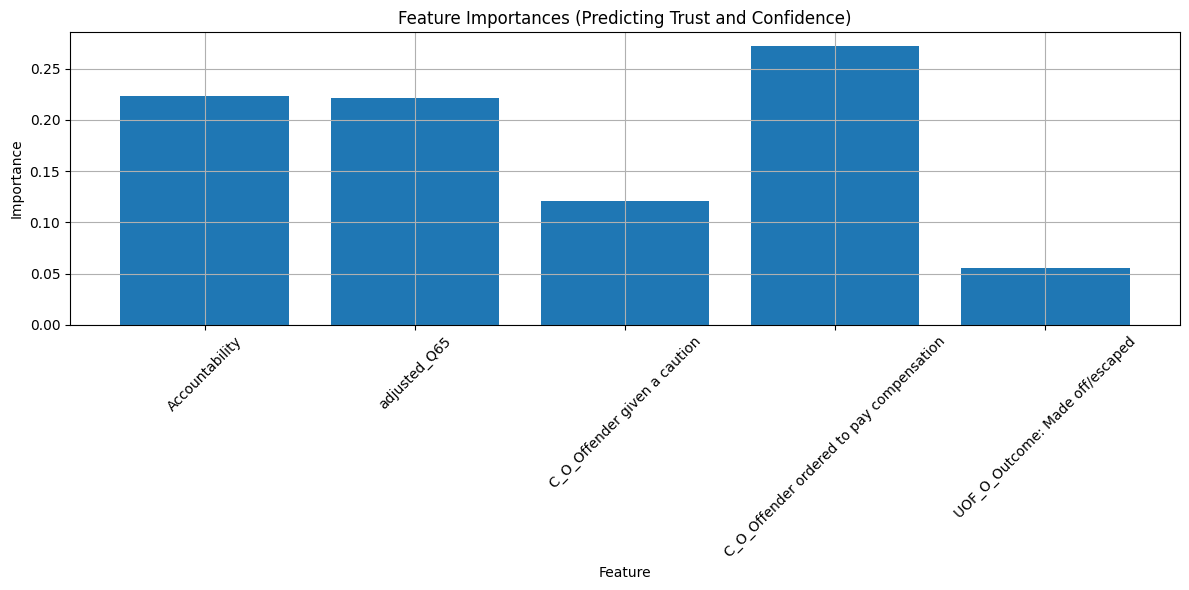

In [187]:
# The goal is to predict the trust and confidence in the police based on the data provided.
# do not split the dataframe randomly - use the last 2 months of data as the test set
# These are [Jan 2020, Feb 2020]
# and the rest as the training set
# y values are 'Trust' and 'Confidence'
# Use xgboost and get feature importances

final_analysis_df['Date'] = pd.to_datetime(final_analysis_df['Date'], format='%b %Y')
train_df = final_analysis_df[final_analysis_df['Date'] < '2020-01-01']
test_df = final_analysis_df[final_analysis_df['Date'] >= '2020-01-01']

X_train = train_df.drop(columns=['Date', 'Trust', 'Confidence'])
y_train = train_df[['Trust', 'Confidence']]
X_test = test_df.drop(columns=['Date', 'Trust', 'Confidence'])
y_test = test_df[['Trust', 'Confidence']]


# Train the model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# get and plot only importances above 0.05
indices = np.where(importances > 0.05)
features = X_train.columns[indices]

plt.figure(figsize=(12, 6))
plt.bar(features, importances[indices], color='tab:blue')
plt.title('Feature Importances (Predicting Trust and Confidence)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

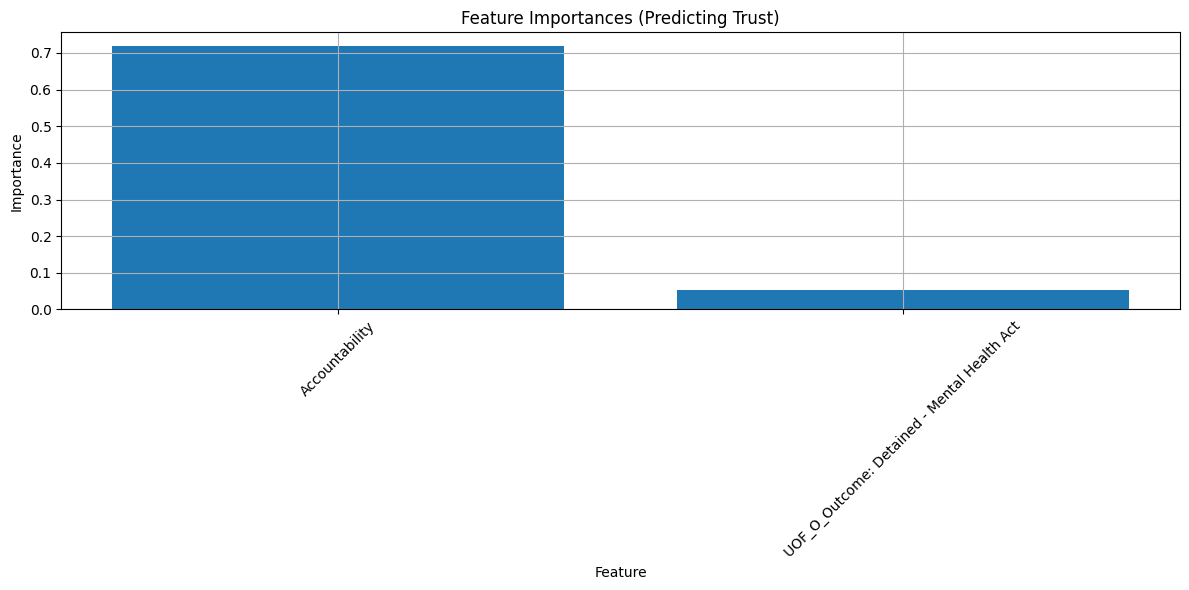

In [188]:
# now predict only Trust as the y value

y_train = train_df['Trust']
y_test = test_df['Trust']

# Train the model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# get and plot only importances above 0.05
indices = np.where(importances > 0.05)
features = X_train.columns[indices]

plt.figure(figsize=(12, 6))
plt.bar(features, importances[indices], color='tab:blue')
plt.title('Feature Importances (Predicting Trust)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

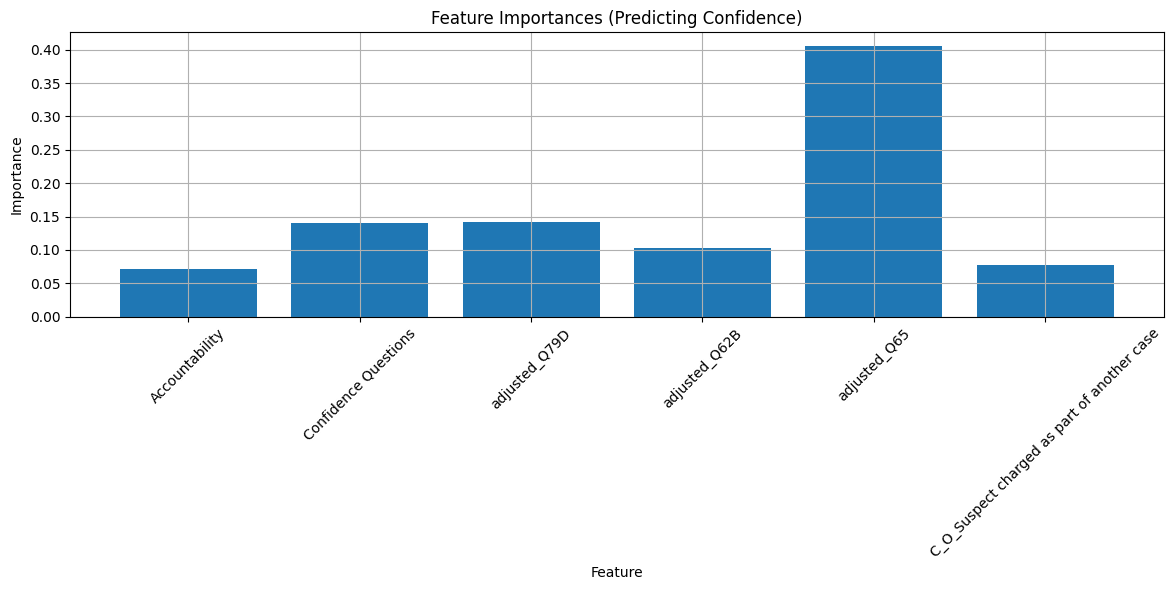

In [189]:
# Now predict only Confidence as the y value

y_train = train_df['Confidence']
y_test = test_df['Confidence']

# Train the model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# get and plot only importances above 0.05
indices = np.where(importances > 0.05)
features = X_train.columns[indices]

plt.figure(figsize=(12, 6))
plt.bar(features, importances[indices], color='tab:blue')
plt.title('Feature Importances (Predicting Confidence)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()